In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

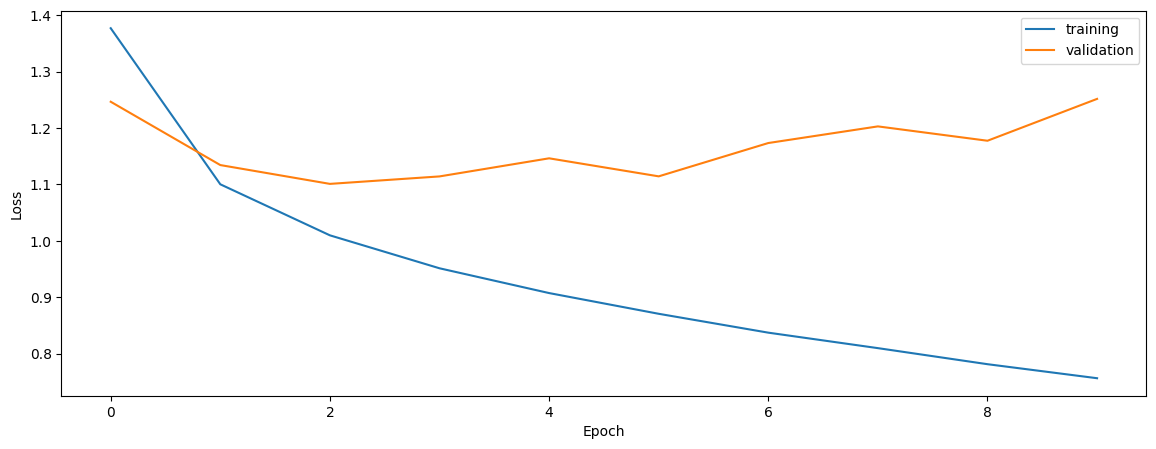

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1254584, 828)
(1254584, 1)
validation
(166224, 828)
(166224, 1)
test
(164640, 828)
(164640, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/126 [..............................] - ETA: 2:22 - loss: 0.2175 - STD: 1.5542e-04 - MAE: 0.4464

  5/126 [>.............................] - ETA: 1s - loss: 0.2234 - STD: 0.0020 - MAE: 0.4485      

  9/126 [=>............................] - ETA: 1s - loss: 0.2218 - STD: 0.0029 - MAE: 0.4407

 12/126 [=>............................] - ETA: 1s - loss: 0.2208 - STD: 0.0038 - MAE: 0.4432

 16/126 [==>...........................] - ETA: 1s - loss: 0.2194 - STD: 0.0049 - MAE: 0.4431

 20/126 [===>..........................] - ETA: 1s - loss: 0.2186 - STD: 0.0065 - MAE: 0.4410

 24/126 [====>.........................] - ETA: 1s - loss: 0.2176 - STD: 0.0088 - MAE: 0.4415

 28/126 [=====>........................] - ETA: 1s - loss: 0.2166 - STD: 0.0121 - MAE: 0.4400

 32/126 [======>.......................] - ETA: 1s - loss: 0.2152 - STD: 0.0176 - MAE: 0.4384

 36/126 [=======>......................] - ETA: 1s - loss: 0.2138 - STD: 0.0253 - MAE: 0.4360

 40/126 [========>.....................] - ETA: 1s - loss: 0.2122 - STD: 0.0353 - MAE: 0.4331

 44/126 [=========>....................] - ETA: 1s - loss: 0.2109 - STD: 0.0450 - MAE: 0.4301

 48/126 [==========>...................] - ETA: 1s - loss: 0.2097 - STD: 0.0528 - MAE: 0.4277

 52/126 [===========>..................] - ETA: 1s - loss: 0.2087 - STD: 0.0587 - MAE: 0.4258

 56/126 [============>.................] - ETA: 1s - loss: 0.2077 - STD: 0.0639 - MAE: 0.4240

 60/126 [=============>................] - ETA: 1s - loss: 0.2067 - STD: 0.0694 - MAE: 0.4221

 64/126 [==============>...............] - ETA: 1s - loss: 0.2058 - STD: 0.0746 - MAE: 0.4201

 68/126 [===============>..............] - ETA: 1s - loss: 0.2048 - STD: 0.0790 - MAE: 0.4184

 72/126 [================>.............] - ETA: 1s - loss: 0.2039 - STD: 0.0830 - MAE: 0.4169

 76/126 [=================>............] - ETA: 1s - loss: 0.2031 - STD: 0.0869 - MAE: 0.4153

 80/126 [==================>...........] - ETA: 1s - loss: 0.2022 - STD: 0.0907 - MAE: 0.4137

 84/126 [===================>..........] - ETA: 0s - loss: 0.2013 - STD: 0.0943 - MAE: 0.4120

 88/126 [===================>..........] - ETA: 0s - loss: 0.2005 - STD: 0.0978 - MAE: 0.4105

 92/126 [====================>.........] - ETA: 0s - loss: 0.1997 - STD: 0.1012 - MAE: 0.4089

 96/126 [=====================>........] - ETA: 0s - loss: 0.1990 - STD: 0.1042 - MAE: 0.4076

100/126 [======================>.......] - ETA: 0s - loss: 0.1983 - STD: 0.1070 - MAE: 0.4063

104/126 [=======================>......] - ETA: 0s - loss: 0.1976 - STD: 0.1097 - MAE: 0.4051

108/126 [========================>.....] - ETA: 0s - loss: 0.1969 - STD: 0.1124 - MAE: 0.4038

112/126 [=========================>....] - ETA: 0s - loss: 0.1963 - STD: 0.1149 - MAE: 0.4026

116/126 [==========================>...] - ETA: 0s - loss: 0.1957 - STD: 0.1173 - MAE: 0.4015

120/126 [===========================>..] - ETA: 0s - loss: 0.1951 - STD: 0.1195 - MAE: 0.4005

124/126 [============================>.] - ETA: 0s - loss: 0.1946 - STD: 0.1217 - MAE: 0.3994

126/126 [==============================] - 4s 26ms/step - loss: 0.1943 - STD: 0.1228 - MAE: 0.3989 - val_loss: 0.1811 - val_STD: 0.1424 - val_MAE: 0.3714


Epoch 2/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1781 - STD: 0.1900 - MAE: 0.3678

  4/126 [..............................] - ETA: 2s - loss: 0.1783 - STD: 0.1915 - MAE: 0.3675

  8/126 [>.............................] - ETA: 1s - loss: 0.1778 - STD: 0.1913 - MAE: 0.3668

 12/126 [=>............................] - ETA: 1s - loss: 0.1775 - STD: 0.1908 - MAE: 0.3664

 16/126 [==>...........................] - ETA: 1s - loss: 0.1776 - STD: 0.1905 - MAE: 0.3664

 20/126 [===>..........................] - ETA: 1s - loss: 0.1778 - STD: 0.1903 - MAE: 0.3665

 24/126 [====>.........................] - ETA: 1s - loss: 0.1780 - STD: 0.1908 - MAE: 0.3666

 28/126 [=====>........................] - ETA: 1s - loss: 0.1779 - STD: 0.1910 - MAE: 0.3663

 32/126 [======>.......................] - ETA: 1s - loss: 0.1778 - STD: 0.1910 - MAE: 0.3662

 36/126 [=======>......................] - ETA: 1s - loss: 0.1778 - STD: 0.1911 - MAE: 0.3662

 40/126 [========>.....................] - ETA: 1s - loss: 0.1775 - STD: 0.1915 - MAE: 0.3659

 44/126 [=========>....................] - ETA: 1s - loss: 0.1775 - STD: 0.1919 - MAE: 0.3657

 48/126 [==========>...................] - ETA: 1s - loss: 0.1775 - STD: 0.1920 - MAE: 0.3656

 52/126 [===========>..................] - ETA: 1s - loss: 0.1773 - STD: 0.1922 - MAE: 0.3654

 56/126 [============>.................] - ETA: 1s - loss: 0.1772 - STD: 0.1927 - MAE: 0.3651

 60/126 [=============>................] - ETA: 0s - loss: 0.1771 - STD: 0.1931 - MAE: 0.3649

 64/126 [==============>...............] - ETA: 0s - loss: 0.1770 - STD: 0.1931 - MAE: 0.3649

 68/126 [===============>..............] - ETA: 0s - loss: 0.1769 - STD: 0.1932 - MAE: 0.3647

 72/126 [================>.............] - ETA: 0s - loss: 0.1769 - STD: 0.1936 - MAE: 0.3647

 76/126 [=================>............] - ETA: 0s - loss: 0.1769 - STD: 0.1940 - MAE: 0.3645

 80/126 [==================>...........] - ETA: 0s - loss: 0.1767 - STD: 0.1941 - MAE: 0.3643

 84/126 [===================>..........] - ETA: 0s - loss: 0.1766 - STD: 0.1945 - MAE: 0.3641

 87/126 [===================>..........] - ETA: 0s - loss: 0.1765 - STD: 0.1947 - MAE: 0.3640

 91/126 [====================>.........] - ETA: 0s - loss: 0.1764 - STD: 0.1949 - MAE: 0.3638

 95/126 [=====================>........] - ETA: 0s - loss: 0.1764 - STD: 0.1951 - MAE: 0.3638

 99/126 [======================>.......] - ETA: 0s - loss: 0.1763 - STD: 0.1955 - MAE: 0.3636

103/126 [=======================>......] - ETA: 0s - loss: 0.1762 - STD: 0.1957 - MAE: 0.3634

107/126 [========================>.....] - ETA: 0s - loss: 0.1760 - STD: 0.1959 - MAE: 0.3632

111/126 [=========================>....] - ETA: 0s - loss: 0.1760 - STD: 0.1964 - MAE: 0.3630

115/126 [==========================>...] - ETA: 0s - loss: 0.1760 - STD: 0.1965 - MAE: 0.3628

119/126 [===========================>..] - ETA: 0s - loss: 0.1759 - STD: 0.1966 - MAE: 0.3627

123/126 [============================>.] - ETA: 0s - loss: 0.1759 - STD: 0.1967 - MAE: 0.3628

126/126 [==============================] - 2s 17ms/step - loss: 0.1759 - STD: 0.1966 - MAE: 0.3627 - val_loss: 0.1752 - val_STD: 0.1598 - val_MAE: 0.3627


Epoch 3/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1722 - STD: 0.2056 - MAE: 0.3585

  5/126 [>.............................] - ETA: 1s - loss: 0.1730 - STD: 0.2056 - MAE: 0.3580

  9/126 [=>............................] - ETA: 1s - loss: 0.1739 - STD: 0.2063 - MAE: 0.3583

 13/126 [==>...........................] - ETA: 1s - loss: 0.1736 - STD: 0.2058 - MAE: 0.3582

 17/126 [===>..........................] - ETA: 1s - loss: 0.1735 - STD: 0.2054 - MAE: 0.3581

 21/126 [====>.........................] - ETA: 1s - loss: 0.1734 - STD: 0.2060 - MAE: 0.3578

 25/126 [====>.........................] - ETA: 1s - loss: 0.1731 - STD: 0.2064 - MAE: 0.3573

 29/126 [=====>........................] - ETA: 1s - loss: 0.1732 - STD: 0.2058 - MAE: 0.3576

 33/126 [======>.......................] - ETA: 1s - loss: 0.1732 - STD: 0.2053 - MAE: 0.3577

 37/126 [=======>......................] - ETA: 1s - loss: 0.1731 - STD: 0.2057 - MAE: 0.3576

 41/126 [========>.....................] - ETA: 1s - loss: 0.1730 - STD: 0.2062 - MAE: 0.3571

 45/126 [=========>....................] - ETA: 1s - loss: 0.1728 - STD: 0.2064 - MAE: 0.3569

 49/126 [==========>...................] - ETA: 1s - loss: 0.1728 - STD: 0.2063 - MAE: 0.3569

 53/126 [===========>..................] - ETA: 1s - loss: 0.1728 - STD: 0.2063 - MAE: 0.3569

 57/126 [============>.................] - ETA: 1s - loss: 0.1727 - STD: 0.2066 - MAE: 0.3567

 61/126 [=============>................] - ETA: 1s - loss: 0.1726 - STD: 0.2068 - MAE: 0.3565

 65/126 [==============>...............] - ETA: 0s - loss: 0.1726 - STD: 0.2067 - MAE: 0.3565

 69/126 [===============>..............] - ETA: 0s - loss: 0.1725 - STD: 0.2067 - MAE: 0.3564

 73/126 [================>.............] - ETA: 0s - loss: 0.1724 - STD: 0.2068 - MAE: 0.3563

 77/126 [=================>............] - ETA: 0s - loss: 0.1724 - STD: 0.2068 - MAE: 0.3562

 81/126 [==================>...........] - ETA: 0s - loss: 0.1722 - STD: 0.2072 - MAE: 0.3559

 85/126 [===================>..........] - ETA: 0s - loss: 0.1721 - STD: 0.2076 - MAE: 0.3557

 89/126 [====================>.........] - ETA: 0s - loss: 0.1720 - STD: 0.2077 - MAE: 0.3555

 93/126 [=====================>........] - ETA: 0s - loss: 0.1719 - STD: 0.2078 - MAE: 0.3554

 97/126 [======================>.......] - ETA: 0s - loss: 0.1720 - STD: 0.2079 - MAE: 0.3554

101/126 [=======================>......] - ETA: 0s - loss: 0.1719 - STD: 0.2079 - MAE: 0.3553

105/126 [========================>.....] - ETA: 0s - loss: 0.1719 - STD: 0.2081 - MAE: 0.3553

109/126 [========================>.....] - ETA: 0s - loss: 0.1720 - STD: 0.2078 - MAE: 0.3553

113/126 [=========================>....] - ETA: 0s - loss: 0.1720 - STD: 0.2079 - MAE: 0.3552

117/126 [==========================>...] - ETA: 0s - loss: 0.1721 - STD: 0.2078 - MAE: 0.3553

121/126 [===========================>..] - ETA: 0s - loss: 0.1722 - STD: 0.2075 - MAE: 0.3554

125/126 [============================>.] - ETA: 0s - loss: 0.1721 - STD: 0.2072 - MAE: 0.3555

126/126 [==============================] - 2s 17ms/step - loss: 0.1722 - STD: 0.2071 - MAE: 0.3555 - val_loss: 0.1751 - val_STD: 0.1476 - val_MAE: 0.3554


Epoch 4/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1744 - STD: 0.1904 - MAE: 0.3547

  5/126 [>.............................] - ETA: 1s - loss: 0.1720 - STD: 0.2045 - MAE: 0.3535

  9/126 [=>............................] - ETA: 1s - loss: 0.1711 - STD: 0.2073 - MAE: 0.3530

 13/126 [==>...........................] - ETA: 1s - loss: 0.1716 - STD: 0.2092 - MAE: 0.3535

 17/126 [===>..........................] - ETA: 1s - loss: 0.1717 - STD: 0.2093 - MAE: 0.3534

 21/126 [====>.........................] - ETA: 1s - loss: 0.1712 - STD: 0.2091 - MAE: 0.3530

 25/126 [====>.........................] - ETA: 1s - loss: 0.1707 - STD: 0.2096 - MAE: 0.3524

 29/126 [=====>........................] - ETA: 1s - loss: 0.1703 - STD: 0.2104 - MAE: 0.3519

 33/126 [======>.......................] - ETA: 1s - loss: 0.1700 - STD: 0.2107 - MAE: 0.3515

 37/126 [=======>......................] - ETA: 1s - loss: 0.1699 - STD: 0.2111 - MAE: 0.3513

 41/126 [========>.....................] - ETA: 1s - loss: 0.1699 - STD: 0.2114 - MAE: 0.3513

 45/126 [=========>....................] - ETA: 1s - loss: 0.1699 - STD: 0.2115 - MAE: 0.3514

 49/126 [==========>...................] - ETA: 1s - loss: 0.1698 - STD: 0.2116 - MAE: 0.3512

 53/126 [===========>..................] - ETA: 1s - loss: 0.1697 - STD: 0.2119 - MAE: 0.3511

 57/126 [============>.................] - ETA: 1s - loss: 0.1696 - STD: 0.2121 - MAE: 0.3510

 61/126 [=============>................] - ETA: 1s - loss: 0.1696 - STD: 0.2124 - MAE: 0.3509

 65/126 [==============>...............] - ETA: 0s - loss: 0.1696 - STD: 0.2127 - MAE: 0.3508

 69/126 [===============>..............] - ETA: 0s - loss: 0.1696 - STD: 0.2126 - MAE: 0.3509

 73/126 [================>.............] - ETA: 0s - loss: 0.1696 - STD: 0.2123 - MAE: 0.3510

 77/126 [=================>............] - ETA: 0s - loss: 0.1695 - STD: 0.2123 - MAE: 0.3509

 81/126 [==================>...........] - ETA: 0s - loss: 0.1695 - STD: 0.2125 - MAE: 0.3508

 85/126 [===================>..........] - ETA: 0s - loss: 0.1694 - STD: 0.2126 - MAE: 0.3506

 89/126 [====================>.........] - ETA: 0s - loss: 0.1693 - STD: 0.2127 - MAE: 0.3506

 93/126 [=====================>........] - ETA: 0s - loss: 0.1693 - STD: 0.2129 - MAE: 0.3505

 97/126 [======================>.......] - ETA: 0s - loss: 0.1693 - STD: 0.2130 - MAE: 0.3505

101/126 [=======================>......] - ETA: 0s - loss: 0.1692 - STD: 0.2132 - MAE: 0.3504

105/126 [========================>.....] - ETA: 0s - loss: 0.1692 - STD: 0.2132 - MAE: 0.3503

109/126 [========================>.....] - ETA: 0s - loss: 0.1693 - STD: 0.2132 - MAE: 0.3504

113/126 [=========================>....] - ETA: 0s - loss: 0.1692 - STD: 0.2133 - MAE: 0.3503

117/126 [==========================>...] - ETA: 0s - loss: 0.1692 - STD: 0.2136 - MAE: 0.3502

121/126 [===========================>..] - ETA: 0s - loss: 0.1693 - STD: 0.2135 - MAE: 0.3503

125/126 [============================>.] - ETA: 0s - loss: 0.1692 - STD: 0.2135 - MAE: 0.3502

126/126 [==============================] - 2s 17ms/step - loss: 0.1692 - STD: 0.2135 - MAE: 0.3503 - val_loss: 0.1694 - val_STD: 0.1628 - val_MAE: 0.3499


Epoch 5/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1669 - STD: 0.2033 - MAE: 0.3464

  5/126 [>.............................] - ETA: 1s - loss: 0.1672 - STD: 0.2125 - MAE: 0.3471

  9/126 [=>............................] - ETA: 1s - loss: 0.1676 - STD: 0.2148 - MAE: 0.3474

 13/126 [==>...........................] - ETA: 1s - loss: 0.1673 - STD: 0.2146 - MAE: 0.3474

 17/126 [===>..........................] - ETA: 1s - loss: 0.1673 - STD: 0.2146 - MAE: 0.3472

 21/126 [====>.........................] - ETA: 1s - loss: 0.1675 - STD: 0.2165 - MAE: 0.3469

 25/126 [====>.........................] - ETA: 1s - loss: 0.1677 - STD: 0.2162 - MAE: 0.3472

 29/126 [=====>........................] - ETA: 1s - loss: 0.1677 - STD: 0.2160 - MAE: 0.3474

 33/126 [======>.......................] - ETA: 1s - loss: 0.1678 - STD: 0.2156 - MAE: 0.3471

 37/126 [=======>......................] - ETA: 1s - loss: 0.1678 - STD: 0.2158 - MAE: 0.3473

 41/126 [========>.....................] - ETA: 1s - loss: 0.1677 - STD: 0.2155 - MAE: 0.3474

 45/126 [=========>....................] - ETA: 1s - loss: 0.1674 - STD: 0.2156 - MAE: 0.3471

 49/126 [==========>...................] - ETA: 1s - loss: 0.1674 - STD: 0.2161 - MAE: 0.3469

 53/126 [===========>..................] - ETA: 1s - loss: 0.1673 - STD: 0.2164 - MAE: 0.3468

 57/126 [============>.................] - ETA: 1s - loss: 0.1673 - STD: 0.2166 - MAE: 0.3467

 61/126 [=============>................] - ETA: 1s - loss: 0.1674 - STD: 0.2166 - MAE: 0.3468

 65/126 [==============>...............] - ETA: 0s - loss: 0.1674 - STD: 0.2166 - MAE: 0.3469

 69/126 [===============>..............] - ETA: 0s - loss: 0.1672 - STD: 0.2168 - MAE: 0.3466

 73/126 [================>.............] - ETA: 0s - loss: 0.1672 - STD: 0.2169 - MAE: 0.3465

 77/126 [=================>............] - ETA: 0s - loss: 0.1673 - STD: 0.2170 - MAE: 0.3466

 81/126 [==================>...........] - ETA: 0s - loss: 0.1672 - STD: 0.2172 - MAE: 0.3463

 85/126 [===================>..........] - ETA: 0s - loss: 0.1671 - STD: 0.2173 - MAE: 0.3462

 89/126 [====================>.........] - ETA: 0s - loss: 0.1670 - STD: 0.2173 - MAE: 0.3461

 93/126 [=====================>........] - ETA: 0s - loss: 0.1670 - STD: 0.2175 - MAE: 0.3460

 97/126 [======================>.......] - ETA: 0s - loss: 0.1669 - STD: 0.2176 - MAE: 0.3459

101/126 [=======================>......] - ETA: 0s - loss: 0.1669 - STD: 0.2175 - MAE: 0.3460

105/126 [========================>.....] - ETA: 0s - loss: 0.1669 - STD: 0.2175 - MAE: 0.3459

109/126 [========================>.....] - ETA: 0s - loss: 0.1668 - STD: 0.2176 - MAE: 0.3458

113/126 [=========================>....] - ETA: 0s - loss: 0.1672 - STD: 0.2174 - MAE: 0.3460

117/126 [==========================>...] - ETA: 0s - loss: 0.1672 - STD: 0.2176 - MAE: 0.3461

121/126 [===========================>..] - ETA: 0s - loss: 0.1671 - STD: 0.2173 - MAE: 0.3461

125/126 [============================>.] - ETA: 0s - loss: 0.1672 - STD: 0.2172 - MAE: 0.3462

126/126 [==============================] - 2s 18ms/step - loss: 0.1672 - STD: 0.2172 - MAE: 0.3461 - val_loss: 0.1656 - val_STD: 0.1718 - val_MAE: 0.3446


Epoch 6/10000


  1/126 [..............................] - ETA: 4s - loss: 0.1629 - STD: 0.2202 - MAE: 0.3401

  5/126 [>.............................] - ETA: 1s - loss: 0.1652 - STD: 0.2202 - MAE: 0.3431

  9/126 [=>............................] - ETA: 1s - loss: 0.1651 - STD: 0.2184 - MAE: 0.3441

 13/126 [==>...........................] - ETA: 1s - loss: 0.1647 - STD: 0.2187 - MAE: 0.3437

 17/126 [===>..........................] - ETA: 1s - loss: 0.1646 - STD: 0.2201 - MAE: 0.3428

 20/126 [===>..........................] - ETA: 1s - loss: 0.1644 - STD: 0.2208 - MAE: 0.3424

 24/126 [====>.........................] - ETA: 1s - loss: 0.1648 - STD: 0.2204 - MAE: 0.3424

 28/126 [=====>........................] - ETA: 1s - loss: 0.1649 - STD: 0.2206 - MAE: 0.3427

 32/126 [======>.......................] - ETA: 1s - loss: 0.1649 - STD: 0.2209 - MAE: 0.3423

 36/126 [=======>......................] - ETA: 1s - loss: 0.1648 - STD: 0.2210 - MAE: 0.3424

 40/126 [========>.....................] - ETA: 1s - loss: 0.1651 - STD: 0.2209 - MAE: 0.3426

 44/126 [=========>....................] - ETA: 1s - loss: 0.1650 - STD: 0.2208 - MAE: 0.3426

 48/126 [==========>...................] - ETA: 1s - loss: 0.1651 - STD: 0.2206 - MAE: 0.3426

 52/126 [===========>..................] - ETA: 1s - loss: 0.1650 - STD: 0.2206 - MAE: 0.3426

 56/126 [============>.................] - ETA: 1s - loss: 0.1653 - STD: 0.2207 - MAE: 0.3427

 60/126 [=============>................] - ETA: 1s - loss: 0.1653 - STD: 0.2208 - MAE: 0.3428

 64/126 [==============>...............] - ETA: 0s - loss: 0.1653 - STD: 0.2203 - MAE: 0.3428

 68/126 [===============>..............] - ETA: 0s - loss: 0.1653 - STD: 0.2205 - MAE: 0.3428

 72/126 [================>.............] - ETA: 0s - loss: 0.1653 - STD: 0.2208 - MAE: 0.3427

 76/126 [=================>............] - ETA: 0s - loss: 0.1652 - STD: 0.2208 - MAE: 0.3427

 80/126 [==================>...........] - ETA: 0s - loss: 0.1652 - STD: 0.2207 - MAE: 0.3427

 84/126 [===================>..........] - ETA: 0s - loss: 0.1652 - STD: 0.2209 - MAE: 0.3427

 88/126 [===================>..........] - ETA: 0s - loss: 0.1652 - STD: 0.2209 - MAE: 0.3425

 92/126 [====================>.........] - ETA: 0s - loss: 0.1651 - STD: 0.2210 - MAE: 0.3425

 95/126 [=====================>........] - ETA: 0s - loss: 0.1651 - STD: 0.2212 - MAE: 0.3424

 99/126 [======================>.......] - ETA: 0s - loss: 0.1651 - STD: 0.2213 - MAE: 0.3424

103/126 [=======================>......] - ETA: 0s - loss: 0.1650 - STD: 0.2214 - MAE: 0.3423

107/126 [========================>.....] - ETA: 0s - loss: 0.1650 - STD: 0.2217 - MAE: 0.3422

111/126 [=========================>....] - ETA: 0s - loss: 0.1651 - STD: 0.2216 - MAE: 0.3423

115/126 [==========================>...] - ETA: 0s - loss: 0.1650 - STD: 0.2215 - MAE: 0.3423

119/126 [===========================>..] - ETA: 0s - loss: 0.1650 - STD: 0.2217 - MAE: 0.3422

123/126 [============================>.] - ETA: 0s - loss: 0.1650 - STD: 0.2217 - MAE: 0.3422

126/126 [==============================] - 2s 18ms/step - loss: 0.1651 - STD: 0.2217 - MAE: 0.3422 - val_loss: 0.1631 - val_STD: 0.1843 - val_MAE: 0.3419


Epoch 7/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1633 - STD: 0.2320 - MAE: 0.3399

  5/126 [>.............................] - ETA: 1s - loss: 0.1640 - STD: 0.2233 - MAE: 0.3413

  9/126 [=>............................] - ETA: 1s - loss: 0.1634 - STD: 0.2230 - MAE: 0.3401

 13/126 [==>...........................] - ETA: 1s - loss: 0.1655 - STD: 0.2236 - MAE: 0.3412

 17/126 [===>..........................] - ETA: 1s - loss: 0.1654 - STD: 0.2230 - MAE: 0.3415

 21/126 [====>.........................] - ETA: 1s - loss: 0.1655 - STD: 0.2214 - MAE: 0.3421

 25/126 [====>.........................] - ETA: 1s - loss: 0.1656 - STD: 0.2226 - MAE: 0.3419

 29/126 [=====>........................] - ETA: 1s - loss: 0.1657 - STD: 0.2217 - MAE: 0.3421

 33/126 [======>.......................] - ETA: 1s - loss: 0.1656 - STD: 0.2215 - MAE: 0.3420

 37/126 [=======>......................] - ETA: 1s - loss: 0.1656 - STD: 0.2215 - MAE: 0.3422

 41/126 [========>.....................] - ETA: 1s - loss: 0.1654 - STD: 0.2214 - MAE: 0.3420

 45/126 [=========>....................] - ETA: 1s - loss: 0.1653 - STD: 0.2217 - MAE: 0.3419

 49/126 [==========>...................] - ETA: 1s - loss: 0.1651 - STD: 0.2216 - MAE: 0.3419

 53/126 [===========>..................] - ETA: 1s - loss: 0.1652 - STD: 0.2218 - MAE: 0.3418

 57/126 [============>.................] - ETA: 1s - loss: 0.1651 - STD: 0.2218 - MAE: 0.3417

 61/126 [=============>................] - ETA: 0s - loss: 0.1651 - STD: 0.2217 - MAE: 0.3419

 65/126 [==============>...............] - ETA: 0s - loss: 0.1650 - STD: 0.2222 - MAE: 0.3415

 69/126 [===============>..............] - ETA: 0s - loss: 0.1648 - STD: 0.2223 - MAE: 0.3414

 73/126 [================>.............] - ETA: 0s - loss: 0.1647 - STD: 0.2225 - MAE: 0.3411

 77/126 [=================>............] - ETA: 0s - loss: 0.1646 - STD: 0.2229 - MAE: 0.3410

 81/126 [==================>...........] - ETA: 0s - loss: 0.1645 - STD: 0.2231 - MAE: 0.3407

 85/126 [===================>..........] - ETA: 0s - loss: 0.1645 - STD: 0.2232 - MAE: 0.3407

 89/126 [====================>.........] - ETA: 0s - loss: 0.1645 - STD: 0.2233 - MAE: 0.3406

 93/126 [=====================>........] - ETA: 0s - loss: 0.1644 - STD: 0.2236 - MAE: 0.3405

 97/126 [======================>.......] - ETA: 0s - loss: 0.1643 - STD: 0.2238 - MAE: 0.3404

101/126 [=======================>......] - ETA: 0s - loss: 0.1644 - STD: 0.2238 - MAE: 0.3405

105/126 [========================>.....] - ETA: 0s - loss: 0.1643 - STD: 0.2239 - MAE: 0.3404

109/126 [========================>.....] - ETA: 0s - loss: 0.1642 - STD: 0.2240 - MAE: 0.3402

113/126 [=========================>....] - ETA: 0s - loss: 0.1642 - STD: 0.2241 - MAE: 0.3401

117/126 [==========================>...] - ETA: 0s - loss: 0.1640 - STD: 0.2242 - MAE: 0.3399

121/126 [===========================>..] - ETA: 0s - loss: 0.1640 - STD: 0.2244 - MAE: 0.3398

125/126 [============================>.] - ETA: 0s - loss: 0.1640 - STD: 0.2244 - MAE: 0.3397

126/126 [==============================] - 2s 17ms/step - loss: 0.1640 - STD: 0.2244 - MAE: 0.3397 - val_loss: 0.1630 - val_STD: 0.1862 - val_MAE: 0.3436


Epoch 8/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1668 - STD: 0.2297 - MAE: 0.3446

  5/126 [>.............................] - ETA: 1s - loss: 0.1643 - STD: 0.2230 - MAE: 0.3376

  9/126 [=>............................] - ETA: 1s - loss: 0.1633 - STD: 0.2243 - MAE: 0.3379

 13/126 [==>...........................] - ETA: 1s - loss: 0.1630 - STD: 0.2247 - MAE: 0.3382

 17/126 [===>..........................] - ETA: 1s - loss: 0.1634 - STD: 0.2249 - MAE: 0.3382

 21/126 [====>.........................] - ETA: 1s - loss: 0.1637 - STD: 0.2247 - MAE: 0.3387

 25/126 [====>.........................] - ETA: 1s - loss: 0.1634 - STD: 0.2250 - MAE: 0.3387

 29/126 [=====>........................] - ETA: 1s - loss: 0.1637 - STD: 0.2251 - MAE: 0.3386

 33/126 [======>.......................] - ETA: 1s - loss: 0.1634 - STD: 0.2251 - MAE: 0.3386

 37/126 [=======>......................] - ETA: 1s - loss: 0.1633 - STD: 0.2255 - MAE: 0.3384

 41/126 [========>.....................] - ETA: 1s - loss: 0.1631 - STD: 0.2259 - MAE: 0.3381

 45/126 [=========>....................] - ETA: 1s - loss: 0.1630 - STD: 0.2259 - MAE: 0.3380

 49/126 [==========>...................] - ETA: 1s - loss: 0.1630 - STD: 0.2261 - MAE: 0.3381

 53/126 [===========>..................] - ETA: 1s - loss: 0.1631 - STD: 0.2264 - MAE: 0.3379

 57/126 [============>.................] - ETA: 1s - loss: 0.1631 - STD: 0.2265 - MAE: 0.3379

 61/126 [=============>................] - ETA: 1s - loss: 0.1631 - STD: 0.2264 - MAE: 0.3379

 65/126 [==============>...............] - ETA: 0s - loss: 0.1630 - STD: 0.2268 - MAE: 0.3377

 69/126 [===============>..............] - ETA: 0s - loss: 0.1628 - STD: 0.2269 - MAE: 0.3375

 73/126 [================>.............] - ETA: 0s - loss: 0.1628 - STD: 0.2268 - MAE: 0.3376

 77/126 [=================>............] - ETA: 0s - loss: 0.1628 - STD: 0.2269 - MAE: 0.3375

 81/126 [==================>...........] - ETA: 0s - loss: 0.1627 - STD: 0.2272 - MAE: 0.3374

 85/126 [===================>..........] - ETA: 0s - loss: 0.1626 - STD: 0.2274 - MAE: 0.3372

 89/126 [====================>.........] - ETA: 0s - loss: 0.1626 - STD: 0.2275 - MAE: 0.3373

 93/126 [=====================>........] - ETA: 0s - loss: 0.1626 - STD: 0.2276 - MAE: 0.3372

 97/126 [======================>.......] - ETA: 0s - loss: 0.1625 - STD: 0.2279 - MAE: 0.3371

101/126 [=======================>......] - ETA: 0s - loss: 0.1626 - STD: 0.2279 - MAE: 0.3370

105/126 [========================>.....] - ETA: 0s - loss: 0.1627 - STD: 0.2280 - MAE: 0.3371

109/126 [========================>.....] - ETA: 0s - loss: 0.1627 - STD: 0.2277 - MAE: 0.3372

113/126 [=========================>....] - ETA: 0s - loss: 0.1628 - STD: 0.2279 - MAE: 0.3372

117/126 [==========================>...] - ETA: 0s - loss: 0.1629 - STD: 0.2279 - MAE: 0.3372

121/126 [===========================>..] - ETA: 0s - loss: 0.1630 - STD: 0.2275 - MAE: 0.3373

125/126 [============================>.] - ETA: 0s - loss: 0.1631 - STD: 0.2276 - MAE: 0.3374

126/126 [==============================] - 2s 17ms/step - loss: 0.1631 - STD: 0.2275 - MAE: 0.3375 - val_loss: 0.1672 - val_STD: 0.1669 - val_MAE: 0.3416


Epoch 9/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1685 - STD: 0.2074 - MAE: 0.3419

  5/126 [>.............................] - ETA: 1s - loss: 0.1647 - STD: 0.2168 - MAE: 0.3423

  9/126 [=>............................] - ETA: 1s - loss: 0.1645 - STD: 0.2224 - MAE: 0.3409

 13/126 [==>...........................] - ETA: 1s - loss: 0.1636 - STD: 0.2232 - MAE: 0.3401

 17/126 [===>..........................] - ETA: 1s - loss: 0.1631 - STD: 0.2238 - MAE: 0.3392

 21/126 [====>.........................] - ETA: 1s - loss: 0.1625 - STD: 0.2252 - MAE: 0.3380

 25/126 [====>.........................] - ETA: 1s - loss: 0.1623 - STD: 0.2253 - MAE: 0.3381

 29/126 [=====>........................] - ETA: 1s - loss: 0.1620 - STD: 0.2266 - MAE: 0.3374

 33/126 [======>.......................] - ETA: 1s - loss: 0.1617 - STD: 0.2274 - MAE: 0.3369

 37/126 [=======>......................] - ETA: 1s - loss: 0.1614 - STD: 0.2279 - MAE: 0.3363

 41/126 [========>.....................] - ETA: 1s - loss: 0.1613 - STD: 0.2285 - MAE: 0.3360

 45/126 [=========>....................] - ETA: 1s - loss: 0.1614 - STD: 0.2286 - MAE: 0.3360

 49/126 [==========>...................] - ETA: 1s - loss: 0.1613 - STD: 0.2290 - MAE: 0.3359

 53/126 [===========>..................] - ETA: 1s - loss: 0.1612 - STD: 0.2294 - MAE: 0.3356

 57/126 [============>.................] - ETA: 1s - loss: 0.1612 - STD: 0.2295 - MAE: 0.3356

 61/126 [=============>................] - ETA: 1s - loss: 0.1611 - STD: 0.2295 - MAE: 0.3354

 65/126 [==============>...............] - ETA: 0s - loss: 0.1611 - STD: 0.2300 - MAE: 0.3353

 69/126 [===============>..............] - ETA: 0s - loss: 0.1613 - STD: 0.2299 - MAE: 0.3354

 73/126 [================>.............] - ETA: 0s - loss: 0.1613 - STD: 0.2301 - MAE: 0.3353

 77/126 [=================>............] - ETA: 0s - loss: 0.1613 - STD: 0.2303 - MAE: 0.3352

 81/126 [==================>...........] - ETA: 0s - loss: 0.1613 - STD: 0.2301 - MAE: 0.3353

 85/126 [===================>..........] - ETA: 0s - loss: 0.1614 - STD: 0.2305 - MAE: 0.3352

 89/126 [====================>.........] - ETA: 0s - loss: 0.1614 - STD: 0.2304 - MAE: 0.3352

 93/126 [=====================>........] - ETA: 0s - loss: 0.1614 - STD: 0.2304 - MAE: 0.3352

 97/126 [======================>.......] - ETA: 0s - loss: 0.1614 - STD: 0.2307 - MAE: 0.3350

101/126 [=======================>......] - ETA: 0s - loss: 0.1613 - STD: 0.2306 - MAE: 0.3350

105/126 [========================>.....] - ETA: 0s - loss: 0.1613 - STD: 0.2306 - MAE: 0.3350

109/126 [========================>.....] - ETA: 0s - loss: 0.1613 - STD: 0.2306 - MAE: 0.3349

113/126 [=========================>....] - ETA: 0s - loss: 0.1613 - STD: 0.2307 - MAE: 0.3351

117/126 [==========================>...] - ETA: 0s - loss: 0.1614 - STD: 0.2305 - MAE: 0.3350

121/126 [===========================>..] - ETA: 0s - loss: 0.1616 - STD: 0.2305 - MAE: 0.3352

125/126 [============================>.] - ETA: 0s - loss: 0.1616 - STD: 0.2304 - MAE: 0.3353

126/126 [==============================] - 2s 18ms/step - loss: 0.1616 - STD: 0.2303 - MAE: 0.3352 - val_loss: 0.1642 - val_STD: 0.1931 - val_MAE: 0.3453


Epoch 10/10000


  1/126 [..............................] - ETA: 4s - loss: 0.1637 - STD: 0.2383 - MAE: 0.3401

  5/126 [>.............................] - ETA: 1s - loss: 0.1620 - STD: 0.2292 - MAE: 0.3380

  9/126 [=>............................] - ETA: 1s - loss: 0.1619 - STD: 0.2284 - MAE: 0.3365

 13/126 [==>...........................] - ETA: 1s - loss: 0.1616 - STD: 0.2302 - MAE: 0.3359

 17/126 [===>..........................] - ETA: 1s - loss: 0.1612 - STD: 0.2298 - MAE: 0.3353

 21/126 [====>.........................] - ETA: 1s - loss: 0.1613 - STD: 0.2307 - MAE: 0.3349

 25/126 [====>.........................] - ETA: 1s - loss: 0.1614 - STD: 0.2304 - MAE: 0.3354

 29/126 [=====>........................] - ETA: 1s - loss: 0.1617 - STD: 0.2301 - MAE: 0.3353

 33/126 [======>.......................] - ETA: 1s - loss: 0.1617 - STD: 0.2298 - MAE: 0.3355

 37/126 [=======>......................] - ETA: 1s - loss: 0.1616 - STD: 0.2299 - MAE: 0.3355

 41/126 [========>.....................] - ETA: 1s - loss: 0.1615 - STD: 0.2299 - MAE: 0.3353

 45/126 [=========>....................] - ETA: 1s - loss: 0.1613 - STD: 0.2301 - MAE: 0.3350

 49/126 [==========>...................] - ETA: 1s - loss: 0.1612 - STD: 0.2303 - MAE: 0.3347

 53/126 [===========>..................] - ETA: 1s - loss: 0.1612 - STD: 0.2305 - MAE: 0.3347

 57/126 [============>.................] - ETA: 1s - loss: 0.1612 - STD: 0.2306 - MAE: 0.3348

 61/126 [=============>................] - ETA: 0s - loss: 0.1612 - STD: 0.2309 - MAE: 0.3346

 65/126 [==============>...............] - ETA: 0s - loss: 0.1611 - STD: 0.2313 - MAE: 0.3344

 69/126 [===============>..............] - ETA: 0s - loss: 0.1611 - STD: 0.2312 - MAE: 0.3343

 73/126 [================>.............] - ETA: 0s - loss: 0.1612 - STD: 0.2313 - MAE: 0.3344

 77/126 [=================>............] - ETA: 0s - loss: 0.1614 - STD: 0.2313 - MAE: 0.3345

 81/126 [==================>...........] - ETA: 0s - loss: 0.1619 - STD: 0.2310 - MAE: 0.3347

 85/126 [===================>..........] - ETA: 0s - loss: 0.1620 - STD: 0.2306 - MAE: 0.3347

 89/126 [====================>.........] - ETA: 0s - loss: 0.1621 - STD: 0.2304 - MAE: 0.3348

 93/126 [=====================>........] - ETA: 0s - loss: 0.1621 - STD: 0.2302 - MAE: 0.3349

 97/126 [======================>.......] - ETA: 0s - loss: 0.1621 - STD: 0.2299 - MAE: 0.3351

101/126 [=======================>......] - ETA: 0s - loss: 0.1621 - STD: 0.2296 - MAE: 0.3353

105/126 [========================>.....] - ETA: 0s - loss: 0.1621 - STD: 0.2295 - MAE: 0.3353

109/126 [========================>.....] - ETA: 0s - loss: 0.1621 - STD: 0.2294 - MAE: 0.3354

113/126 [=========================>....] - ETA: 0s - loss: 0.1620 - STD: 0.2293 - MAE: 0.3353

117/126 [==========================>...] - ETA: 0s - loss: 0.1619 - STD: 0.2295 - MAE: 0.3352

121/126 [===========================>..] - ETA: 0s - loss: 0.1619 - STD: 0.2294 - MAE: 0.3353

125/126 [============================>.] - ETA: 0s - loss: 0.1619 - STD: 0.2293 - MAE: 0.3354

126/126 [==============================] - 2s 17ms/step - loss: 0.1619 - STD: 0.2293 - MAE: 0.3353 - val_loss: 0.1614 - val_STD: 0.1915 - val_MAE: 0.3401


Epoch 11/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1604 - STD: 0.2361 - MAE: 0.3333

  5/126 [>.............................] - ETA: 1s - loss: 0.1595 - STD: 0.2318 - MAE: 0.3331

  9/126 [=>............................] - ETA: 1s - loss: 0.1603 - STD: 0.2319 - MAE: 0.3326

 13/126 [==>...........................] - ETA: 1s - loss: 0.1605 - STD: 0.2321 - MAE: 0.3324

 17/126 [===>..........................] - ETA: 1s - loss: 0.1611 - STD: 0.2322 - MAE: 0.3335

 21/126 [====>.........................] - ETA: 1s - loss: 0.1610 - STD: 0.2325 - MAE: 0.3334

 25/126 [====>.........................] - ETA: 1s - loss: 0.1610 - STD: 0.2320 - MAE: 0.3333

 29/126 [=====>........................] - ETA: 1s - loss: 0.1608 - STD: 0.2321 - MAE: 0.3333

 33/126 [======>.......................] - ETA: 1s - loss: 0.1607 - STD: 0.2325 - MAE: 0.3332

 37/126 [=======>......................] - ETA: 1s - loss: 0.1604 - STD: 0.2325 - MAE: 0.3328

 41/126 [========>.....................] - ETA: 1s - loss: 0.1604 - STD: 0.2325 - MAE: 0.3328

 45/126 [=========>....................] - ETA: 1s - loss: 0.1607 - STD: 0.2324 - MAE: 0.3332

 49/126 [==========>...................] - ETA: 1s - loss: 0.1609 - STD: 0.2325 - MAE: 0.3332

 53/126 [===========>..................] - ETA: 1s - loss: 0.1608 - STD: 0.2326 - MAE: 0.3331

 57/126 [============>.................] - ETA: 1s - loss: 0.1608 - STD: 0.2327 - MAE: 0.3332

 61/126 [=============>................] - ETA: 1s - loss: 0.1607 - STD: 0.2329 - MAE: 0.3331

 65/126 [==============>...............] - ETA: 0s - loss: 0.1606 - STD: 0.2328 - MAE: 0.3331

 69/126 [===============>..............] - ETA: 0s - loss: 0.1605 - STD: 0.2329 - MAE: 0.3330

 73/126 [================>.............] - ETA: 0s - loss: 0.1605 - STD: 0.2328 - MAE: 0.3330

 77/126 [=================>............] - ETA: 0s - loss: 0.1604 - STD: 0.2331 - MAE: 0.3328

 81/126 [==================>...........] - ETA: 0s - loss: 0.1602 - STD: 0.2332 - MAE: 0.3326

 85/126 [===================>..........] - ETA: 0s - loss: 0.1601 - STD: 0.2336 - MAE: 0.3324

 89/126 [====================>.........] - ETA: 0s - loss: 0.1601 - STD: 0.2340 - MAE: 0.3323

 93/126 [=====================>........] - ETA: 0s - loss: 0.1602 - STD: 0.2338 - MAE: 0.3324

 97/126 [======================>.......] - ETA: 0s - loss: 0.1603 - STD: 0.2341 - MAE: 0.3323

101/126 [=======================>......] - ETA: 0s - loss: 0.1603 - STD: 0.2342 - MAE: 0.3324

105/126 [========================>.....] - ETA: 0s - loss: 0.1605 - STD: 0.2339 - MAE: 0.3325

109/126 [========================>.....] - ETA: 0s - loss: 0.1606 - STD: 0.2340 - MAE: 0.3324

113/126 [=========================>....] - ETA: 0s - loss: 0.1607 - STD: 0.2337 - MAE: 0.3327

117/126 [==========================>...] - ETA: 0s - loss: 0.1608 - STD: 0.2337 - MAE: 0.3328

121/126 [===========================>..] - ETA: 0s - loss: 0.1608 - STD: 0.2332 - MAE: 0.3329

125/126 [============================>.] - ETA: 0s - loss: 0.1608 - STD: 0.2331 - MAE: 0.3329

126/126 [==============================] - 2s 17ms/step - loss: 0.1608 - STD: 0.2331 - MAE: 0.3329 - val_loss: 0.1619 - val_STD: 0.1903 - val_MAE: 0.3430


Epoch 12/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1592 - STD: 0.2332 - MAE: 0.3355

  5/126 [>.............................] - ETA: 1s - loss: 0.1599 - STD: 0.2291 - MAE: 0.3351

  9/126 [=>............................] - ETA: 1s - loss: 0.1594 - STD: 0.2301 - MAE: 0.3341

 13/126 [==>...........................] - ETA: 1s - loss: 0.1590 - STD: 0.2312 - MAE: 0.3329

 17/126 [===>..........................] - ETA: 1s - loss: 0.1591 - STD: 0.2316 - MAE: 0.3328

 21/126 [====>.........................] - ETA: 1s - loss: 0.1591 - STD: 0.2322 - MAE: 0.3326

 25/126 [====>.........................] - ETA: 1s - loss: 0.1589 - STD: 0.2331 - MAE: 0.3318

 29/126 [=====>........................] - ETA: 1s - loss: 0.1589 - STD: 0.2332 - MAE: 0.3316

 33/126 [======>.......................] - ETA: 1s - loss: 0.1591 - STD: 0.2338 - MAE: 0.3316

 37/126 [=======>......................] - ETA: 1s - loss: 0.1593 - STD: 0.2344 - MAE: 0.3315

 41/126 [========>.....................] - ETA: 1s - loss: 0.1595 - STD: 0.2340 - MAE: 0.3316

 45/126 [=========>....................] - ETA: 1s - loss: 0.1596 - STD: 0.2341 - MAE: 0.3315

 49/126 [==========>...................] - ETA: 1s - loss: 0.1597 - STD: 0.2341 - MAE: 0.3318

 53/126 [===========>..................] - ETA: 1s - loss: 0.1597 - STD: 0.2342 - MAE: 0.3317

 57/126 [============>.................] - ETA: 1s - loss: 0.1597 - STD: 0.2340 - MAE: 0.3317

 61/126 [=============>................] - ETA: 1s - loss: 0.1596 - STD: 0.2340 - MAE: 0.3316

 65/126 [==============>...............] - ETA: 0s - loss: 0.1595 - STD: 0.2340 - MAE: 0.3317

 69/126 [===============>..............] - ETA: 0s - loss: 0.1595 - STD: 0.2343 - MAE: 0.3316

 73/126 [================>.............] - ETA: 0s - loss: 0.1594 - STD: 0.2344 - MAE: 0.3315

 77/126 [=================>............] - ETA: 0s - loss: 0.1594 - STD: 0.2343 - MAE: 0.3314

 81/126 [==================>...........] - ETA: 0s - loss: 0.1595 - STD: 0.2345 - MAE: 0.3314

 85/126 [===================>..........] - ETA: 0s - loss: 0.1595 - STD: 0.2344 - MAE: 0.3315

 89/126 [====================>.........] - ETA: 0s - loss: 0.1594 - STD: 0.2345 - MAE: 0.3313

 93/126 [=====================>........] - ETA: 0s - loss: 0.1594 - STD: 0.2346 - MAE: 0.3312

 97/126 [======================>.......] - ETA: 0s - loss: 0.1595 - STD: 0.2347 - MAE: 0.3313

101/126 [=======================>......] - ETA: 0s - loss: 0.1595 - STD: 0.2346 - MAE: 0.3313

105/126 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.2346 - MAE: 0.3312

109/126 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.2346 - MAE: 0.3313

113/126 [=========================>....] - ETA: 0s - loss: 0.1596 - STD: 0.2346 - MAE: 0.3313

117/126 [==========================>...] - ETA: 0s - loss: 0.1596 - STD: 0.2346 - MAE: 0.3313

121/126 [===========================>..] - ETA: 0s - loss: 0.1596 - STD: 0.2347 - MAE: 0.3313

125/126 [============================>.] - ETA: 0s - loss: 0.1595 - STD: 0.2347 - MAE: 0.3313

126/126 [==============================] - 2s 18ms/step - loss: 0.1595 - STD: 0.2347 - MAE: 0.3313 - val_loss: 0.1603 - val_STD: 0.1883 - val_MAE: 0.3378


Epoch 13/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1588 - STD: 0.2310 - MAE: 0.3326

  5/126 [>.............................] - ETA: 1s - loss: 0.1592 - STD: 0.2349 - MAE: 0.3305

  9/126 [=>............................] - ETA: 1s - loss: 0.1589 - STD: 0.2372 - MAE: 0.3299

 13/126 [==>...........................] - ETA: 1s - loss: 0.1587 - STD: 0.2370 - MAE: 0.3297

 17/126 [===>..........................] - ETA: 1s - loss: 0.1587 - STD: 0.2374 - MAE: 0.3298

 21/126 [====>.........................] - ETA: 1s - loss: 0.1587 - STD: 0.2372 - MAE: 0.3296

 25/126 [====>.........................] - ETA: 1s - loss: 0.1587 - STD: 0.2377 - MAE: 0.3295

 29/126 [=====>........................] - ETA: 1s - loss: 0.1587 - STD: 0.2376 - MAE: 0.3296

 33/126 [======>.......................] - ETA: 1s - loss: 0.1592 - STD: 0.2369 - MAE: 0.3297

 37/126 [=======>......................] - ETA: 1s - loss: 0.1595 - STD: 0.2372 - MAE: 0.3296

 41/126 [========>.....................] - ETA: 1s - loss: 0.1596 - STD: 0.2371 - MAE: 0.3298

 45/126 [=========>....................] - ETA: 1s - loss: 0.1600 - STD: 0.2362 - MAE: 0.3302

 49/126 [==========>...................] - ETA: 1s - loss: 0.1602 - STD: 0.2355 - MAE: 0.3305

 53/126 [===========>..................] - ETA: 1s - loss: 0.1601 - STD: 0.2351 - MAE: 0.3306

 57/126 [============>.................] - ETA: 1s - loss: 0.1601 - STD: 0.2351 - MAE: 0.3308

 61/126 [=============>................] - ETA: 0s - loss: 0.1601 - STD: 0.2348 - MAE: 0.3309

 65/126 [==============>...............] - ETA: 0s - loss: 0.1599 - STD: 0.2347 - MAE: 0.3308

 69/126 [===============>..............] - ETA: 0s - loss: 0.1600 - STD: 0.2346 - MAE: 0.3309

 73/126 [================>.............] - ETA: 0s - loss: 0.1599 - STD: 0.2345 - MAE: 0.3310

 77/126 [=================>............] - ETA: 0s - loss: 0.1598 - STD: 0.2349 - MAE: 0.3307

 81/126 [==================>...........] - ETA: 0s - loss: 0.1598 - STD: 0.2349 - MAE: 0.3308

 85/126 [===================>..........] - ETA: 0s - loss: 0.1597 - STD: 0.2351 - MAE: 0.3307

 89/126 [====================>.........] - ETA: 0s - loss: 0.1597 - STD: 0.2351 - MAE: 0.3307

 93/126 [=====================>........] - ETA: 0s - loss: 0.1596 - STD: 0.2351 - MAE: 0.3306

 97/126 [======================>.......] - ETA: 0s - loss: 0.1595 - STD: 0.2354 - MAE: 0.3305

101/126 [=======================>......] - ETA: 0s - loss: 0.1595 - STD: 0.2354 - MAE: 0.3305

105/126 [========================>.....] - ETA: 0s - loss: 0.1594 - STD: 0.2355 - MAE: 0.3303

109/126 [========================>.....] - ETA: 0s - loss: 0.1594 - STD: 0.2356 - MAE: 0.3303

113/126 [=========================>....] - ETA: 0s - loss: 0.1594 - STD: 0.2355 - MAE: 0.3304

117/126 [==========================>...] - ETA: 0s - loss: 0.1594 - STD: 0.2356 - MAE: 0.3303

121/126 [===========================>..] - ETA: 0s - loss: 0.1594 - STD: 0.2358 - MAE: 0.3303

125/126 [============================>.] - ETA: 0s - loss: 0.1594 - STD: 0.2358 - MAE: 0.3303

126/126 [==============================] - 2s 17ms/step - loss: 0.1594 - STD: 0.2358 - MAE: 0.3303 - val_loss: 0.1645 - val_STD: 0.2030 - val_MAE: 0.3438


Epoch 14/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1639 - STD: 0.2449 - MAE: 0.3375

  5/126 [>.............................] - ETA: 1s - loss: 0.1600 - STD: 0.2389 - MAE: 0.3302

  9/126 [=>............................] - ETA: 1s - loss: 0.1594 - STD: 0.2374 - MAE: 0.3295

 13/126 [==>...........................] - ETA: 1s - loss: 0.1593 - STD: 0.2382 - MAE: 0.3297

 17/126 [===>..........................] - ETA: 1s - loss: 0.1589 - STD: 0.2381 - MAE: 0.3293

 21/126 [====>.........................] - ETA: 1s - loss: 0.1584 - STD: 0.2374 - MAE: 0.3288

 25/126 [====>.........................] - ETA: 1s - loss: 0.1583 - STD: 0.2382 - MAE: 0.3286

 29/126 [=====>........................] - ETA: 1s - loss: 0.1582 - STD: 0.2372 - MAE: 0.3290

 33/126 [======>.......................] - ETA: 1s - loss: 0.1579 - STD: 0.2382 - MAE: 0.3282

 37/126 [=======>......................] - ETA: 1s - loss: 0.1576 - STD: 0.2383 - MAE: 0.3280

 41/126 [========>.....................] - ETA: 1s - loss: 0.1575 - STD: 0.2389 - MAE: 0.3277

 45/126 [=========>....................] - ETA: 1s - loss: 0.1577 - STD: 0.2387 - MAE: 0.3276

 49/126 [==========>...................] - ETA: 1s - loss: 0.1580 - STD: 0.2387 - MAE: 0.3278

 53/126 [===========>..................] - ETA: 1s - loss: 0.1589 - STD: 0.2386 - MAE: 0.3285

 57/126 [============>.................] - ETA: 1s - loss: 0.1594 - STD: 0.2376 - MAE: 0.3290

 61/126 [=============>................] - ETA: 0s - loss: 0.1598 - STD: 0.2372 - MAE: 0.3292

 65/126 [==============>...............] - ETA: 0s - loss: 0.1601 - STD: 0.2363 - MAE: 0.3298

 69/126 [===============>..............] - ETA: 0s - loss: 0.1601 - STD: 0.2358 - MAE: 0.3299

 73/126 [================>.............] - ETA: 0s - loss: 0.1602 - STD: 0.2356 - MAE: 0.3301

 77/126 [=================>............] - ETA: 0s - loss: 0.1602 - STD: 0.2349 - MAE: 0.3304

 81/126 [==================>...........] - ETA: 0s - loss: 0.1602 - STD: 0.2350 - MAE: 0.3305

 85/126 [===================>..........] - ETA: 0s - loss: 0.1602 - STD: 0.2348 - MAE: 0.3306

 89/126 [====================>.........] - ETA: 0s - loss: 0.1601 - STD: 0.2345 - MAE: 0.3307

 93/126 [=====================>........] - ETA: 0s - loss: 0.1601 - STD: 0.2343 - MAE: 0.3307

 97/126 [======================>.......] - ETA: 0s - loss: 0.1600 - STD: 0.2343 - MAE: 0.3306

101/126 [=======================>......] - ETA: 0s - loss: 0.1599 - STD: 0.2344 - MAE: 0.3306

105/126 [========================>.....] - ETA: 0s - loss: 0.1598 - STD: 0.2343 - MAE: 0.3306

109/126 [========================>.....] - ETA: 0s - loss: 0.1597 - STD: 0.2344 - MAE: 0.3306

113/126 [=========================>....] - ETA: 0s - loss: 0.1598 - STD: 0.2344 - MAE: 0.3306

117/126 [==========================>...] - ETA: 0s - loss: 0.1597 - STD: 0.2344 - MAE: 0.3306

121/126 [===========================>..] - ETA: 0s - loss: 0.1596 - STD: 0.2347 - MAE: 0.3305

125/126 [============================>.] - ETA: 0s - loss: 0.1596 - STD: 0.2347 - MAE: 0.3306

126/126 [==============================] - 2s 17ms/step - loss: 0.1596 - STD: 0.2347 - MAE: 0.3305 - val_loss: 0.1623 - val_STD: 0.1876 - val_MAE: 0.3313


Epoch 15/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1605 - STD: 0.2345 - MAE: 0.3252

  4/126 [..............................] - ETA: 2s - loss: 0.1584 - STD: 0.2388 - MAE: 0.3266

  8/126 [>.............................] - ETA: 1s - loss: 0.1579 - STD: 0.2379 - MAE: 0.3267

 12/126 [=>............................] - ETA: 1s - loss: 0.1583 - STD: 0.2387 - MAE: 0.3276

 16/126 [==>...........................] - ETA: 1s - loss: 0.1590 - STD: 0.2376 - MAE: 0.3291

 20/126 [===>..........................] - ETA: 1s - loss: 0.1589 - STD: 0.2377 - MAE: 0.3291

 24/126 [====>.........................] - ETA: 1s - loss: 0.1587 - STD: 0.2383 - MAE: 0.3285

 28/126 [=====>........................] - ETA: 1s - loss: 0.1584 - STD: 0.2375 - MAE: 0.3286

 32/126 [======>.......................] - ETA: 1s - loss: 0.1582 - STD: 0.2382 - MAE: 0.3282

 36/126 [=======>......................] - ETA: 1s - loss: 0.1582 - STD: 0.2375 - MAE: 0.3287

 40/126 [========>.....................] - ETA: 1s - loss: 0.1580 - STD: 0.2383 - MAE: 0.3282

 44/126 [=========>....................] - ETA: 1s - loss: 0.1579 - STD: 0.2382 - MAE: 0.3282

 48/126 [==========>...................] - ETA: 1s - loss: 0.1576 - STD: 0.2385 - MAE: 0.3278

 52/126 [===========>..................] - ETA: 1s - loss: 0.1575 - STD: 0.2391 - MAE: 0.3276

 56/126 [============>.................] - ETA: 1s - loss: 0.1575 - STD: 0.2391 - MAE: 0.3276

 60/126 [=============>................] - ETA: 1s - loss: 0.1576 - STD: 0.2394 - MAE: 0.3275

 64/126 [==============>...............] - ETA: 0s - loss: 0.1575 - STD: 0.2394 - MAE: 0.3275

 68/126 [===============>..............] - ETA: 0s - loss: 0.1574 - STD: 0.2396 - MAE: 0.3273

 72/126 [================>.............] - ETA: 0s - loss: 0.1574 - STD: 0.2397 - MAE: 0.3272

 76/126 [=================>............] - ETA: 0s - loss: 0.1573 - STD: 0.2399 - MAE: 0.3270

 80/126 [==================>...........] - ETA: 0s - loss: 0.1573 - STD: 0.2399 - MAE: 0.3270

 84/126 [===================>..........] - ETA: 0s - loss: 0.1573 - STD: 0.2400 - MAE: 0.3269

 88/126 [===================>..........] - ETA: 0s - loss: 0.1573 - STD: 0.2401 - MAE: 0.3268

 92/126 [====================>.........] - ETA: 0s - loss: 0.1574 - STD: 0.2400 - MAE: 0.3270

 96/126 [=====================>........] - ETA: 0s - loss: 0.1575 - STD: 0.2398 - MAE: 0.3270

100/126 [======================>.......] - ETA: 0s - loss: 0.1575 - STD: 0.2399 - MAE: 0.3269

104/126 [=======================>......] - ETA: 0s - loss: 0.1574 - STD: 0.2399 - MAE: 0.3269

108/126 [========================>.....] - ETA: 0s - loss: 0.1574 - STD: 0.2400 - MAE: 0.3268

112/126 [=========================>....] - ETA: 0s - loss: 0.1574 - STD: 0.2400 - MAE: 0.3269

116/126 [==========================>...] - ETA: 0s - loss: 0.1573 - STD: 0.2401 - MAE: 0.3267

120/126 [===========================>..] - ETA: 0s - loss: 0.1572 - STD: 0.2402 - MAE: 0.3267

124/126 [============================>.] - ETA: 0s - loss: 0.1572 - STD: 0.2402 - MAE: 0.3266

126/126 [==============================] - 2s 18ms/step - loss: 0.1572 - STD: 0.2403 - MAE: 0.3266 - val_loss: 0.1600 - val_STD: 0.1926 - val_MAE: 0.3309


Epoch 16/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1568 - STD: 0.2361 - MAE: 0.3242

  5/126 [>.............................] - ETA: 1s - loss: 0.1568 - STD: 0.2384 - MAE: 0.3264

  9/126 [=>............................] - ETA: 1s - loss: 0.1571 - STD: 0.2414 - MAE: 0.3261

 13/126 [==>...........................] - ETA: 1s - loss: 0.1567 - STD: 0.2404 - MAE: 0.3261

 17/126 [===>..........................] - ETA: 1s - loss: 0.1569 - STD: 0.2420 - MAE: 0.3259

 21/126 [====>.........................] - ETA: 1s - loss: 0.1566 - STD: 0.2421 - MAE: 0.3257

 25/126 [====>.........................] - ETA: 1s - loss: 0.1566 - STD: 0.2425 - MAE: 0.3257

 29/126 [=====>........................] - ETA: 1s - loss: 0.1566 - STD: 0.2420 - MAE: 0.3255

 33/126 [======>.......................] - ETA: 1s - loss: 0.1565 - STD: 0.2422 - MAE: 0.3255

 37/126 [=======>......................] - ETA: 1s - loss: 0.1568 - STD: 0.2420 - MAE: 0.3254

 41/126 [========>.....................] - ETA: 1s - loss: 0.1567 - STD: 0.2421 - MAE: 0.3253

 45/126 [=========>....................] - ETA: 1s - loss: 0.1567 - STD: 0.2422 - MAE: 0.3252

 49/126 [==========>...................] - ETA: 1s - loss: 0.1566 - STD: 0.2423 - MAE: 0.3251

 53/126 [===========>..................] - ETA: 1s - loss: 0.1564 - STD: 0.2425 - MAE: 0.3249

 57/126 [============>.................] - ETA: 1s - loss: 0.1565 - STD: 0.2422 - MAE: 0.3251

 61/126 [=============>................] - ETA: 1s - loss: 0.1567 - STD: 0.2422 - MAE: 0.3253

 65/126 [==============>...............] - ETA: 0s - loss: 0.1567 - STD: 0.2422 - MAE: 0.3253

 69/126 [===============>..............] - ETA: 0s - loss: 0.1567 - STD: 0.2422 - MAE: 0.3252

 73/126 [================>.............] - ETA: 0s - loss: 0.1567 - STD: 0.2423 - MAE: 0.3251

 77/126 [=================>............] - ETA: 0s - loss: 0.1566 - STD: 0.2423 - MAE: 0.3251

 81/126 [==================>...........] - ETA: 0s - loss: 0.1566 - STD: 0.2423 - MAE: 0.3250

 85/126 [===================>..........] - ETA: 0s - loss: 0.1566 - STD: 0.2422 - MAE: 0.3251

 89/126 [====================>.........] - ETA: 0s - loss: 0.1565 - STD: 0.2422 - MAE: 0.3249

 93/126 [=====================>........] - ETA: 0s - loss: 0.1566 - STD: 0.2422 - MAE: 0.3250

 97/126 [======================>.......] - ETA: 0s - loss: 0.1566 - STD: 0.2419 - MAE: 0.3251

101/126 [=======================>......] - ETA: 0s - loss: 0.1567 - STD: 0.2421 - MAE: 0.3251

105/126 [========================>.....] - ETA: 0s - loss: 0.1568 - STD: 0.2419 - MAE: 0.3252

109/126 [========================>.....] - ETA: 0s - loss: 0.1568 - STD: 0.2419 - MAE: 0.3252

113/126 [=========================>....] - ETA: 0s - loss: 0.1570 - STD: 0.2417 - MAE: 0.3253

117/126 [==========================>...] - ETA: 0s - loss: 0.1570 - STD: 0.2418 - MAE: 0.3253

121/126 [===========================>..] - ETA: 0s - loss: 0.1571 - STD: 0.2414 - MAE: 0.3254

125/126 [============================>.] - ETA: 0s - loss: 0.1571 - STD: 0.2414 - MAE: 0.3254

126/126 [==============================] - 2s 17ms/step - loss: 0.1571 - STD: 0.2414 - MAE: 0.3255 - val_loss: 0.1596 - val_STD: 0.1837 - val_MAE: 0.3374


Epoch 17/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1571 - STD: 0.2288 - MAE: 0.3304

  5/126 [>.............................] - ETA: 1s - loss: 0.1561 - STD: 0.2385 - MAE: 0.3251

  8/126 [>.............................] - ETA: 1s - loss: 0.1567 - STD: 0.2395 - MAE: 0.3259

 12/126 [=>............................] - ETA: 1s - loss: 0.1569 - STD: 0.2379 - MAE: 0.3270

 16/126 [==>...........................] - ETA: 1s - loss: 0.1564 - STD: 0.2406 - MAE: 0.3255

 20/126 [===>..........................] - ETA: 1s - loss: 0.1562 - STD: 0.2399 - MAE: 0.3259

 24/126 [====>.........................] - ETA: 1s - loss: 0.1560 - STD: 0.2408 - MAE: 0.3253

 28/126 [=====>........................] - ETA: 1s - loss: 0.1559 - STD: 0.2403 - MAE: 0.3255

 32/126 [======>.......................] - ETA: 1s - loss: 0.1558 - STD: 0.2417 - MAE: 0.3248

 36/126 [=======>......................] - ETA: 1s - loss: 0.1557 - STD: 0.2416 - MAE: 0.3248

 40/126 [========>.....................] - ETA: 1s - loss: 0.1557 - STD: 0.2420 - MAE: 0.3246

 44/126 [=========>....................] - ETA: 1s - loss: 0.1557 - STD: 0.2421 - MAE: 0.3245

 48/126 [==========>...................] - ETA: 1s - loss: 0.1557 - STD: 0.2425 - MAE: 0.3245

 52/126 [===========>..................] - ETA: 1s - loss: 0.1559 - STD: 0.2422 - MAE: 0.3244

 56/126 [============>.................] - ETA: 1s - loss: 0.1561 - STD: 0.2422 - MAE: 0.3246

 60/126 [=============>................] - ETA: 1s - loss: 0.1566 - STD: 0.2422 - MAE: 0.3249

 64/126 [==============>...............] - ETA: 0s - loss: 0.1572 - STD: 0.2416 - MAE: 0.3253

 68/126 [===============>..............] - ETA: 0s - loss: 0.1576 - STD: 0.2411 - MAE: 0.3256

 72/126 [================>.............] - ETA: 0s - loss: 0.1575 - STD: 0.2410 - MAE: 0.3256

 76/126 [=================>............] - ETA: 0s - loss: 0.1575 - STD: 0.2405 - MAE: 0.3259

 80/126 [==================>...........] - ETA: 0s - loss: 0.1575 - STD: 0.2405 - MAE: 0.3259

 84/126 [===================>..........] - ETA: 0s - loss: 0.1573 - STD: 0.2403 - MAE: 0.3259

 88/126 [===================>..........] - ETA: 0s - loss: 0.1572 - STD: 0.2405 - MAE: 0.3258

 92/126 [====================>.........] - ETA: 0s - loss: 0.1571 - STD: 0.2402 - MAE: 0.3258

 96/126 [=====================>........] - ETA: 0s - loss: 0.1569 - STD: 0.2405 - MAE: 0.3255

100/126 [======================>.......] - ETA: 0s - loss: 0.1569 - STD: 0.2403 - MAE: 0.3256

104/126 [=======================>......] - ETA: 0s - loss: 0.1568 - STD: 0.2405 - MAE: 0.3255

107/126 [========================>.....] - ETA: 0s - loss: 0.1568 - STD: 0.2406 - MAE: 0.3255

111/126 [=========================>....] - ETA: 0s - loss: 0.1569 - STD: 0.2405 - MAE: 0.3256

115/126 [==========================>...] - ETA: 0s - loss: 0.1569 - STD: 0.2408 - MAE: 0.3254

119/126 [===========================>..] - ETA: 0s - loss: 0.1568 - STD: 0.2407 - MAE: 0.3254

123/126 [============================>.] - ETA: 0s - loss: 0.1568 - STD: 0.2408 - MAE: 0.3254

126/126 [==============================] - 2s 18ms/step - loss: 0.1568 - STD: 0.2407 - MAE: 0.3254 - val_loss: 0.1587 - val_STD: 0.1921 - val_MAE: 0.3333


Epoch 18/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1560 - STD: 0.2358 - MAE: 0.3252

  5/126 [>.............................] - ETA: 1s - loss: 0.1561 - STD: 0.2463 - MAE: 0.3230

  9/126 [=>............................] - ETA: 1s - loss: 0.1558 - STD: 0.2426 - MAE: 0.3242

 13/126 [==>...........................] - ETA: 1s - loss: 0.1556 - STD: 0.2435 - MAE: 0.3238

 17/126 [===>..........................] - ETA: 1s - loss: 0.1556 - STD: 0.2427 - MAE: 0.3240

 21/126 [====>.........................] - ETA: 1s - loss: 0.1551 - STD: 0.2434 - MAE: 0.3232

 25/126 [====>.........................] - ETA: 1s - loss: 0.1548 - STD: 0.2444 - MAE: 0.3227

 29/126 [=====>........................] - ETA: 1s - loss: 0.1548 - STD: 0.2445 - MAE: 0.3225

 33/126 [======>.......................] - ETA: 1s - loss: 0.1547 - STD: 0.2446 - MAE: 0.3224

 36/126 [=======>......................] - ETA: 1s - loss: 0.1548 - STD: 0.2446 - MAE: 0.3227

 40/126 [========>.....................] - ETA: 1s - loss: 0.1547 - STD: 0.2447 - MAE: 0.3224

 44/126 [=========>....................] - ETA: 1s - loss: 0.1549 - STD: 0.2446 - MAE: 0.3225

 48/126 [==========>...................] - ETA: 1s - loss: 0.1552 - STD: 0.2446 - MAE: 0.3227

 52/126 [===========>..................] - ETA: 1s - loss: 0.1553 - STD: 0.2443 - MAE: 0.3228

 56/126 [============>.................] - ETA: 1s - loss: 0.1556 - STD: 0.2441 - MAE: 0.3233

 60/126 [=============>................] - ETA: 1s - loss: 0.1558 - STD: 0.2438 - MAE: 0.3232

 64/126 [==============>...............] - ETA: 0s - loss: 0.1559 - STD: 0.2437 - MAE: 0.3233

 68/126 [===============>..............] - ETA: 0s - loss: 0.1559 - STD: 0.2436 - MAE: 0.3234

 72/126 [================>.............] - ETA: 0s - loss: 0.1559 - STD: 0.2436 - MAE: 0.3235

 76/126 [=================>............] - ETA: 0s - loss: 0.1558 - STD: 0.2435 - MAE: 0.3234

 80/126 [==================>...........] - ETA: 0s - loss: 0.1557 - STD: 0.2436 - MAE: 0.3233

 84/126 [===================>..........] - ETA: 0s - loss: 0.1557 - STD: 0.2436 - MAE: 0.3233

 88/126 [===================>..........] - ETA: 0s - loss: 0.1558 - STD: 0.2437 - MAE: 0.3233

 92/126 [====================>.........] - ETA: 0s - loss: 0.1558 - STD: 0.2436 - MAE: 0.3233

 96/126 [=====================>........] - ETA: 0s - loss: 0.1557 - STD: 0.2437 - MAE: 0.3233

100/126 [======================>.......] - ETA: 0s - loss: 0.1557 - STD: 0.2437 - MAE: 0.3233

104/126 [=======================>......] - ETA: 0s - loss: 0.1557 - STD: 0.2436 - MAE: 0.3233

108/126 [========================>.....] - ETA: 0s - loss: 0.1556 - STD: 0.2436 - MAE: 0.3233

112/126 [=========================>....] - ETA: 0s - loss: 0.1556 - STD: 0.2436 - MAE: 0.3232

116/126 [==========================>...] - ETA: 0s - loss: 0.1556 - STD: 0.2437 - MAE: 0.3232

120/126 [===========================>..] - ETA: 0s - loss: 0.1556 - STD: 0.2438 - MAE: 0.3232

124/126 [============================>.] - ETA: 0s - loss: 0.1556 - STD: 0.2437 - MAE: 0.3231

126/126 [==============================] - 2s 18ms/step - loss: 0.1556 - STD: 0.2437 - MAE: 0.3232 - val_loss: 0.1586 - val_STD: 0.1926 - val_MAE: 0.3288


Epoch 19/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1566 - STD: 0.2417 - MAE: 0.3223

  4/126 [..............................] - ETA: 2s - loss: 0.1561 - STD: 0.2438 - MAE: 0.3239

  8/126 [>.............................] - ETA: 1s - loss: 0.1547 - STD: 0.2450 - MAE: 0.3221

 12/126 [=>............................] - ETA: 1s - loss: 0.1549 - STD: 0.2444 - MAE: 0.3228

 16/126 [==>...........................] - ETA: 1s - loss: 0.1548 - STD: 0.2445 - MAE: 0.3225

 20/126 [===>..........................] - ETA: 1s - loss: 0.1546 - STD: 0.2450 - MAE: 0.3224

 24/126 [====>.........................] - ETA: 1s - loss: 0.1545 - STD: 0.2452 - MAE: 0.3220

 28/126 [=====>........................] - ETA: 1s - loss: 0.1547 - STD: 0.2450 - MAE: 0.3224

 32/126 [======>.......................] - ETA: 1s - loss: 0.1544 - STD: 0.2453 - MAE: 0.3218

 36/126 [=======>......................] - ETA: 1s - loss: 0.1543 - STD: 0.2458 - MAE: 0.3215

 40/126 [========>.....................] - ETA: 1s - loss: 0.1543 - STD: 0.2457 - MAE: 0.3215

 44/126 [=========>....................] - ETA: 1s - loss: 0.1542 - STD: 0.2458 - MAE: 0.3215

 48/126 [==========>...................] - ETA: 1s - loss: 0.1542 - STD: 0.2462 - MAE: 0.3213

 52/126 [===========>..................] - ETA: 1s - loss: 0.1543 - STD: 0.2463 - MAE: 0.3214

 56/126 [============>.................] - ETA: 1s - loss: 0.1544 - STD: 0.2461 - MAE: 0.3213

 60/126 [=============>................] - ETA: 1s - loss: 0.1545 - STD: 0.2464 - MAE: 0.3213

 64/126 [==============>...............] - ETA: 0s - loss: 0.1547 - STD: 0.2464 - MAE: 0.3215

 68/126 [===============>..............] - ETA: 0s - loss: 0.1548 - STD: 0.2461 - MAE: 0.3216

 72/126 [================>.............] - ETA: 0s - loss: 0.1550 - STD: 0.2461 - MAE: 0.3216

 76/126 [=================>............] - ETA: 0s - loss: 0.1552 - STD: 0.2461 - MAE: 0.3217

 80/126 [==================>...........] - ETA: 0s - loss: 0.1558 - STD: 0.2453 - MAE: 0.3222

 84/126 [===================>..........] - ETA: 0s - loss: 0.1559 - STD: 0.2453 - MAE: 0.3221

 88/126 [===================>..........] - ETA: 0s - loss: 0.1559 - STD: 0.2447 - MAE: 0.3224

 92/126 [====================>.........] - ETA: 0s - loss: 0.1558 - STD: 0.2446 - MAE: 0.3225

 96/126 [=====================>........] - ETA: 0s - loss: 0.1557 - STD: 0.2444 - MAE: 0.3225

100/126 [======================>.......] - ETA: 0s - loss: 0.1556 - STD: 0.2443 - MAE: 0.3224

104/126 [=======================>......] - ETA: 0s - loss: 0.1556 - STD: 0.2441 - MAE: 0.3224

108/126 [========================>.....] - ETA: 0s - loss: 0.1555 - STD: 0.2441 - MAE: 0.3224

112/126 [=========================>....] - ETA: 0s - loss: 0.1555 - STD: 0.2440 - MAE: 0.3224

116/126 [==========================>...] - ETA: 0s - loss: 0.1554 - STD: 0.2441 - MAE: 0.3224

120/126 [===========================>..] - ETA: 0s - loss: 0.1554 - STD: 0.2440 - MAE: 0.3225

124/126 [============================>.] - ETA: 0s - loss: 0.1554 - STD: 0.2440 - MAE: 0.3225

126/126 [==============================] - 2s 17ms/step - loss: 0.1555 - STD: 0.2441 - MAE: 0.3226 - val_loss: 0.1582 - val_STD: 0.1931 - val_MAE: 0.3331


Epoch 20/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1551 - STD: 0.2379 - MAE: 0.3248

  5/126 [>.............................] - ETA: 1s - loss: 0.1546 - STD: 0.2446 - MAE: 0.3232

  9/126 [=>............................] - ETA: 1s - loss: 0.1539 - STD: 0.2460 - MAE: 0.3208

 13/126 [==>...........................] - ETA: 1s - loss: 0.1537 - STD: 0.2468 - MAE: 0.3205

 17/126 [===>..........................] - ETA: 1s - loss: 0.1535 - STD: 0.2470 - MAE: 0.3200

 21/126 [====>.........................] - ETA: 1s - loss: 0.1533 - STD: 0.2470 - MAE: 0.3199

 25/126 [====>.........................] - ETA: 1s - loss: 0.1536 - STD: 0.2466 - MAE: 0.3204

 29/126 [=====>........................] - ETA: 1s - loss: 0.1537 - STD: 0.2463 - MAE: 0.3205

 33/126 [======>.......................] - ETA: 1s - loss: 0.1538 - STD: 0.2465 - MAE: 0.3206

 36/126 [=======>......................] - ETA: 1s - loss: 0.1537 - STD: 0.2469 - MAE: 0.3204

 40/126 [========>.....................] - ETA: 1s - loss: 0.1537 - STD: 0.2469 - MAE: 0.3204

 44/126 [=========>....................] - ETA: 1s - loss: 0.1538 - STD: 0.2471 - MAE: 0.3204

 48/126 [==========>...................] - ETA: 1s - loss: 0.1538 - STD: 0.2471 - MAE: 0.3205

 52/126 [===========>..................] - ETA: 1s - loss: 0.1539 - STD: 0.2470 - MAE: 0.3207

 56/126 [============>.................] - ETA: 1s - loss: 0.1541 - STD: 0.2469 - MAE: 0.3206

 60/126 [=============>................] - ETA: 1s - loss: 0.1541 - STD: 0.2471 - MAE: 0.3206

 64/126 [==============>...............] - ETA: 0s - loss: 0.1541 - STD: 0.2471 - MAE: 0.3206

 68/126 [===============>..............] - ETA: 0s - loss: 0.1541 - STD: 0.2468 - MAE: 0.3206

 72/126 [================>.............] - ETA: 0s - loss: 0.1541 - STD: 0.2468 - MAE: 0.3206

 76/126 [=================>............] - ETA: 0s - loss: 0.1540 - STD: 0.2468 - MAE: 0.3205

 80/126 [==================>...........] - ETA: 0s - loss: 0.1540 - STD: 0.2469 - MAE: 0.3204

 84/126 [===================>..........] - ETA: 0s - loss: 0.1540 - STD: 0.2472 - MAE: 0.3203

 88/126 [===================>..........] - ETA: 0s - loss: 0.1544 - STD: 0.2468 - MAE: 0.3205

 92/126 [====================>.........] - ETA: 0s - loss: 0.1549 - STD: 0.2463 - MAE: 0.3207

 96/126 [=====================>........] - ETA: 0s - loss: 0.1553 - STD: 0.2461 - MAE: 0.3212

100/126 [======================>.......] - ETA: 0s - loss: 0.1555 - STD: 0.2455 - MAE: 0.3215

104/126 [=======================>......] - ETA: 0s - loss: 0.1557 - STD: 0.2454 - MAE: 0.3217

108/126 [========================>.....] - ETA: 0s - loss: 0.1557 - STD: 0.2449 - MAE: 0.3219

112/126 [=========================>....] - ETA: 0s - loss: 0.1557 - STD: 0.2448 - MAE: 0.3219

116/126 [==========================>...] - ETA: 0s - loss: 0.1556 - STD: 0.2446 - MAE: 0.3219

120/126 [===========================>..] - ETA: 0s - loss: 0.1556 - STD: 0.2442 - MAE: 0.3221

124/126 [============================>.] - ETA: 0s - loss: 0.1555 - STD: 0.2442 - MAE: 0.3221

126/126 [==============================] - 2s 17ms/step - loss: 0.1555 - STD: 0.2442 - MAE: 0.3221 - val_loss: 0.1579 - val_STD: 0.1851 - val_MAE: 0.3327


Epoch 21/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1527 - STD: 0.2331 - MAE: 0.3225

  5/126 [>.............................] - ETA: 1s - loss: 0.1532 - STD: 0.2402 - MAE: 0.3222

  9/126 [=>............................] - ETA: 1s - loss: 0.1535 - STD: 0.2425 - MAE: 0.3219

 13/126 [==>...........................] - ETA: 1s - loss: 0.1535 - STD: 0.2422 - MAE: 0.3223

 17/126 [===>..........................] - ETA: 1s - loss: 0.1534 - STD: 0.2426 - MAE: 0.3218

 21/126 [====>.........................] - ETA: 1s - loss: 0.1533 - STD: 0.2435 - MAE: 0.3214

 25/126 [====>.........................] - ETA: 1s - loss: 0.1529 - STD: 0.2443 - MAE: 0.3207

 29/126 [=====>........................] - ETA: 1s - loss: 0.1530 - STD: 0.2448 - MAE: 0.3207

 33/126 [======>.......................] - ETA: 1s - loss: 0.1530 - STD: 0.2450 - MAE: 0.3203

 37/126 [=======>......................] - ETA: 1s - loss: 0.1532 - STD: 0.2454 - MAE: 0.3201

 41/126 [========>.....................] - ETA: 1s - loss: 0.1537 - STD: 0.2457 - MAE: 0.3206

 45/126 [=========>....................] - ETA: 1s - loss: 0.1539 - STD: 0.2458 - MAE: 0.3205

 49/126 [==========>...................] - ETA: 1s - loss: 0.1541 - STD: 0.2455 - MAE: 0.3205

 53/126 [===========>..................] - ETA: 1s - loss: 0.1543 - STD: 0.2454 - MAE: 0.3208

 57/126 [============>.................] - ETA: 1s - loss: 0.1544 - STD: 0.2457 - MAE: 0.3209

 61/126 [=============>................] - ETA: 1s - loss: 0.1544 - STD: 0.2453 - MAE: 0.3210

 65/126 [==============>...............] - ETA: 0s - loss: 0.1545 - STD: 0.2455 - MAE: 0.3209

 69/126 [===============>..............] - ETA: 0s - loss: 0.1546 - STD: 0.2450 - MAE: 0.3212

 73/126 [================>.............] - ETA: 0s - loss: 0.1545 - STD: 0.2452 - MAE: 0.3211

 77/126 [=================>............] - ETA: 0s - loss: 0.1544 - STD: 0.2451 - MAE: 0.3211

 81/126 [==================>...........] - ETA: 0s - loss: 0.1544 - STD: 0.2452 - MAE: 0.3211

 85/126 [===================>..........] - ETA: 0s - loss: 0.1544 - STD: 0.2452 - MAE: 0.3211

 89/126 [====================>.........] - ETA: 0s - loss: 0.1543 - STD: 0.2452 - MAE: 0.3210

 93/126 [=====================>........] - ETA: 0s - loss: 0.1543 - STD: 0.2453 - MAE: 0.3210

 97/126 [======================>.......] - ETA: 0s - loss: 0.1543 - STD: 0.2453 - MAE: 0.3210

101/126 [=======================>......] - ETA: 0s - loss: 0.1543 - STD: 0.2454 - MAE: 0.3208

105/126 [========================>.....] - ETA: 0s - loss: 0.1544 - STD: 0.2455 - MAE: 0.3209

109/126 [========================>.....] - ETA: 0s - loss: 0.1544 - STD: 0.2456 - MAE: 0.3208

113/126 [=========================>....] - ETA: 0s - loss: 0.1544 - STD: 0.2455 - MAE: 0.3209

117/126 [==========================>...] - ETA: 0s - loss: 0.1544 - STD: 0.2456 - MAE: 0.3209

121/126 [===========================>..] - ETA: 0s - loss: 0.1545 - STD: 0.2455 - MAE: 0.3209

125/126 [============================>.] - ETA: 0s - loss: 0.1546 - STD: 0.2455 - MAE: 0.3210

126/126 [==============================] - 2s 17ms/step - loss: 0.1546 - STD: 0.2455 - MAE: 0.3210 - val_loss: 0.1582 - val_STD: 0.1978 - val_MAE: 0.3373


Epoch 22/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1546 - STD: 0.2393 - MAE: 0.3266

  5/126 [>.............................] - ETA: 1s - loss: 0.1546 - STD: 0.2428 - MAE: 0.3241

  9/126 [=>............................] - ETA: 1s - loss: 0.1534 - STD: 0.2429 - MAE: 0.3220

 13/126 [==>...........................] - ETA: 1s - loss: 0.1536 - STD: 0.2438 - MAE: 0.3215

 17/126 [===>..........................] - ETA: 1s - loss: 0.1532 - STD: 0.2440 - MAE: 0.3211

 21/126 [====>.........................] - ETA: 1s - loss: 0.1532 - STD: 0.2448 - MAE: 0.3208

 25/126 [====>.........................] - ETA: 1s - loss: 0.1531 - STD: 0.2452 - MAE: 0.3204

 28/126 [=====>........................] - ETA: 1s - loss: 0.1533 - STD: 0.2455 - MAE: 0.3203

 32/126 [======>.......................] - ETA: 1s - loss: 0.1539 - STD: 0.2453 - MAE: 0.3203

 36/126 [=======>......................] - ETA: 1s - loss: 0.1547 - STD: 0.2454 - MAE: 0.3209

 39/126 [========>.....................] - ETA: 1s - loss: 0.1546 - STD: 0.2452 - MAE: 0.3208

 43/126 [=========>....................] - ETA: 1s - loss: 0.1546 - STD: 0.2457 - MAE: 0.3207

 46/126 [=========>....................] - ETA: 1s - loss: 0.1545 - STD: 0.2458 - MAE: 0.3205

 50/126 [==========>...................] - ETA: 1s - loss: 0.1545 - STD: 0.2459 - MAE: 0.3205

 54/126 [===========>..................] - ETA: 1s - loss: 0.1543 - STD: 0.2458 - MAE: 0.3205

 58/126 [============>.................] - ETA: 1s - loss: 0.1541 - STD: 0.2460 - MAE: 0.3203

 62/126 [=============>................] - ETA: 1s - loss: 0.1540 - STD: 0.2460 - MAE: 0.3202

 66/126 [==============>...............] - ETA: 0s - loss: 0.1539 - STD: 0.2461 - MAE: 0.3202

 70/126 [===============>..............] - ETA: 0s - loss: 0.1538 - STD: 0.2463 - MAE: 0.3200

 74/126 [================>.............] - ETA: 0s - loss: 0.1538 - STD: 0.2462 - MAE: 0.3200

 78/126 [=================>............] - ETA: 0s - loss: 0.1538 - STD: 0.2464 - MAE: 0.3200

 82/126 [==================>...........] - ETA: 0s - loss: 0.1537 - STD: 0.2466 - MAE: 0.3199

 86/126 [===================>..........] - ETA: 0s - loss: 0.1536 - STD: 0.2468 - MAE: 0.3197

 90/126 [====================>.........] - ETA: 0s - loss: 0.1535 - STD: 0.2469 - MAE: 0.3196

 94/126 [=====================>........] - ETA: 0s - loss: 0.1534 - STD: 0.2472 - MAE: 0.3194

 98/126 [======================>.......] - ETA: 0s - loss: 0.1534 - STD: 0.2472 - MAE: 0.3194

102/126 [=======================>......] - ETA: 0s - loss: 0.1533 - STD: 0.2474 - MAE: 0.3192

106/126 [========================>.....] - ETA: 0s - loss: 0.1533 - STD: 0.2474 - MAE: 0.3193

110/126 [=========================>....] - ETA: 0s - loss: 0.1532 - STD: 0.2476 - MAE: 0.3191

114/126 [==========================>...] - ETA: 0s - loss: 0.1532 - STD: 0.2475 - MAE: 0.3191

118/126 [===========================>..] - ETA: 0s - loss: 0.1531 - STD: 0.2479 - MAE: 0.3189

122/126 [============================>.] - ETA: 0s - loss: 0.1531 - STD: 0.2480 - MAE: 0.3189

126/126 [==============================] - ETA: 0s - loss: 0.1531 - STD: 0.2480 - MAE: 0.3188

126/126 [==============================] - 2s 18ms/step - loss: 0.1531 - STD: 0.2480 - MAE: 0.3188 - val_loss: 0.1592 - val_STD: 0.2021 - val_MAE: 0.3402


Epoch 23/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1549 - STD: 0.2454 - MAE: 0.3289

  5/126 [>.............................] - ETA: 1s - loss: 0.1532 - STD: 0.2547 - MAE: 0.3150

  9/126 [=>............................] - ETA: 1s - loss: 0.1530 - STD: 0.2508 - MAE: 0.3180

 13/126 [==>...........................] - ETA: 1s - loss: 0.1531 - STD: 0.2529 - MAE: 0.3168

 17/126 [===>..........................] - ETA: 1s - loss: 0.1530 - STD: 0.2511 - MAE: 0.3178

 21/126 [====>.........................] - ETA: 1s - loss: 0.1527 - STD: 0.2509 - MAE: 0.3175

 25/126 [====>.........................] - ETA: 1s - loss: 0.1531 - STD: 0.2504 - MAE: 0.3179

 29/126 [=====>........................] - ETA: 1s - loss: 0.1529 - STD: 0.2500 - MAE: 0.3179

 33/126 [======>.......................] - ETA: 1s - loss: 0.1530 - STD: 0.2505 - MAE: 0.3178

 37/126 [=======>......................] - ETA: 1s - loss: 0.1536 - STD: 0.2494 - MAE: 0.3180

 41/126 [========>.....................] - ETA: 1s - loss: 0.1544 - STD: 0.2493 - MAE: 0.3184

 45/126 [=========>....................] - ETA: 1s - loss: 0.1555 - STD: 0.2485 - MAE: 0.3196

 49/126 [==========>...................] - ETA: 1s - loss: 0.1557 - STD: 0.2487 - MAE: 0.3196

 53/126 [===========>..................] - ETA: 1s - loss: 0.1556 - STD: 0.2473 - MAE: 0.3202

 57/126 [============>.................] - ETA: 1s - loss: 0.1554 - STD: 0.2478 - MAE: 0.3198

 61/126 [=============>................] - ETA: 1s - loss: 0.1552 - STD: 0.2469 - MAE: 0.3201

 65/126 [==============>...............] - ETA: 0s - loss: 0.1550 - STD: 0.2469 - MAE: 0.3201

 69/126 [===============>..............] - ETA: 0s - loss: 0.1549 - STD: 0.2463 - MAE: 0.3204

 73/126 [================>.............] - ETA: 0s - loss: 0.1547 - STD: 0.2464 - MAE: 0.3202

 77/126 [=================>............] - ETA: 0s - loss: 0.1546 - STD: 0.2463 - MAE: 0.3202

 81/126 [==================>...........] - ETA: 0s - loss: 0.1545 - STD: 0.2465 - MAE: 0.3200

 85/126 [===================>..........] - ETA: 0s - loss: 0.1543 - STD: 0.2465 - MAE: 0.3199

 89/126 [====================>.........] - ETA: 0s - loss: 0.1542 - STD: 0.2467 - MAE: 0.3197

 93/126 [=====================>........] - ETA: 0s - loss: 0.1541 - STD: 0.2469 - MAE: 0.3195

 97/126 [======================>.......] - ETA: 0s - loss: 0.1540 - STD: 0.2470 - MAE: 0.3195

101/126 [=======================>......] - ETA: 0s - loss: 0.1539 - STD: 0.2473 - MAE: 0.3193

105/126 [========================>.....] - ETA: 0s - loss: 0.1538 - STD: 0.2474 - MAE: 0.3193

109/126 [========================>.....] - ETA: 0s - loss: 0.1538 - STD: 0.2475 - MAE: 0.3192

113/126 [=========================>....] - ETA: 0s - loss: 0.1538 - STD: 0.2475 - MAE: 0.3192

117/126 [==========================>...] - ETA: 0s - loss: 0.1537 - STD: 0.2477 - MAE: 0.3191

121/126 [===========================>..] - ETA: 0s - loss: 0.1536 - STD: 0.2478 - MAE: 0.3190

125/126 [============================>.] - ETA: 0s - loss: 0.1536 - STD: 0.2479 - MAE: 0.3189

126/126 [==============================] - 2s 17ms/step - loss: 0.1536 - STD: 0.2479 - MAE: 0.3189 - val_loss: 0.1556 - val_STD: 0.2029 - val_MAE: 0.3287


Epoch 24/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1493 - STD: 0.2503 - MAE: 0.3155

  5/126 [>.............................] - ETA: 1s - loss: 0.1520 - STD: 0.2518 - MAE: 0.3159

  9/126 [=>............................] - ETA: 1s - loss: 0.1525 - STD: 0.2514 - MAE: 0.3176

 13/126 [==>...........................] - ETA: 1s - loss: 0.1525 - STD: 0.2504 - MAE: 0.3173

 17/126 [===>..........................] - ETA: 1s - loss: 0.1522 - STD: 0.2505 - MAE: 0.3170

 21/126 [====>.........................] - ETA: 1s - loss: 0.1519 - STD: 0.2511 - MAE: 0.3164

 25/126 [====>.........................] - ETA: 1s - loss: 0.1517 - STD: 0.2510 - MAE: 0.3162

 29/126 [=====>........................] - ETA: 1s - loss: 0.1519 - STD: 0.2516 - MAE: 0.3164

 33/126 [======>.......................] - ETA: 1s - loss: 0.1519 - STD: 0.2515 - MAE: 0.3164

 37/126 [=======>......................] - ETA: 1s - loss: 0.1520 - STD: 0.2513 - MAE: 0.3166

 41/126 [========>.....................] - ETA: 1s - loss: 0.1520 - STD: 0.2515 - MAE: 0.3164

 45/126 [=========>....................] - ETA: 1s - loss: 0.1519 - STD: 0.2516 - MAE: 0.3163

 49/126 [==========>...................] - ETA: 1s - loss: 0.1518 - STD: 0.2519 - MAE: 0.3161

 53/126 [===========>..................] - ETA: 1s - loss: 0.1520 - STD: 0.2515 - MAE: 0.3163

 57/126 [============>.................] - ETA: 1s - loss: 0.1520 - STD: 0.2518 - MAE: 0.3162

 61/126 [=============>................] - ETA: 0s - loss: 0.1523 - STD: 0.2514 - MAE: 0.3163

 65/126 [==============>...............] - ETA: 0s - loss: 0.1525 - STD: 0.2513 - MAE: 0.3164

 69/126 [===============>..............] - ETA: 0s - loss: 0.1529 - STD: 0.2510 - MAE: 0.3170

 73/126 [================>.............] - ETA: 0s - loss: 0.1532 - STD: 0.2510 - MAE: 0.3170

 77/126 [=================>............] - ETA: 0s - loss: 0.1534 - STD: 0.2501 - MAE: 0.3175

 81/126 [==================>...........] - ETA: 0s - loss: 0.1533 - STD: 0.2504 - MAE: 0.3173

 85/126 [===================>..........] - ETA: 0s - loss: 0.1532 - STD: 0.2501 - MAE: 0.3175

 89/126 [====================>.........] - ETA: 0s - loss: 0.1532 - STD: 0.2502 - MAE: 0.3174

 93/126 [=====================>........] - ETA: 0s - loss: 0.1531 - STD: 0.2498 - MAE: 0.3175

 97/126 [======================>.......] - ETA: 0s - loss: 0.1531 - STD: 0.2499 - MAE: 0.3174

101/126 [=======================>......] - ETA: 0s - loss: 0.1530 - STD: 0.2496 - MAE: 0.3175

105/126 [========================>.....] - ETA: 0s - loss: 0.1530 - STD: 0.2497 - MAE: 0.3176

109/126 [========================>.....] - ETA: 0s - loss: 0.1530 - STD: 0.2494 - MAE: 0.3176

113/126 [=========================>....] - ETA: 0s - loss: 0.1529 - STD: 0.2495 - MAE: 0.3175

117/126 [==========================>...] - ETA: 0s - loss: 0.1529 - STD: 0.2494 - MAE: 0.3176

121/126 [===========================>..] - ETA: 0s - loss: 0.1529 - STD: 0.2496 - MAE: 0.3174

125/126 [============================>.] - ETA: 0s - loss: 0.1528 - STD: 0.2497 - MAE: 0.3174

126/126 [==============================] - 2s 17ms/step - loss: 0.1527 - STD: 0.2498 - MAE: 0.3173 - val_loss: 0.1576 - val_STD: 0.2083 - val_MAE: 0.3232


Epoch 25/10000


  1/126 [..............................] - ETA: 4s - loss: 0.1536 - STD: 0.2588 - MAE: 0.3131

  5/126 [>.............................] - ETA: 1s - loss: 0.1534 - STD: 0.2526 - MAE: 0.3181

  9/126 [=>............................] - ETA: 1s - loss: 0.1527 - STD: 0.2521 - MAE: 0.3169

 13/126 [==>...........................] - ETA: 1s - loss: 0.1519 - STD: 0.2522 - MAE: 0.3163

 17/126 [===>..........................] - ETA: 1s - loss: 0.1513 - STD: 0.2528 - MAE: 0.3154

 21/126 [====>.........................] - ETA: 1s - loss: 0.1516 - STD: 0.2525 - MAE: 0.3159

 25/126 [====>.........................] - ETA: 1s - loss: 0.1517 - STD: 0.2522 - MAE: 0.3161

 29/126 [=====>........................] - ETA: 1s - loss: 0.1518 - STD: 0.2519 - MAE: 0.3162

 33/126 [======>.......................] - ETA: 1s - loss: 0.1516 - STD: 0.2520 - MAE: 0.3159

 37/126 [=======>......................] - ETA: 1s - loss: 0.1517 - STD: 0.2522 - MAE: 0.3158

 41/126 [========>.....................] - ETA: 1s - loss: 0.1519 - STD: 0.2515 - MAE: 0.3160

 45/126 [=========>....................] - ETA: 1s - loss: 0.1518 - STD: 0.2518 - MAE: 0.3158

 49/126 [==========>...................] - ETA: 1s - loss: 0.1518 - STD: 0.2515 - MAE: 0.3160

 53/126 [===========>..................] - ETA: 1s - loss: 0.1520 - STD: 0.2512 - MAE: 0.3162

 57/126 [============>.................] - ETA: 1s - loss: 0.1519 - STD: 0.2515 - MAE: 0.3160

 61/126 [=============>................] - ETA: 1s - loss: 0.1520 - STD: 0.2512 - MAE: 0.3161

 65/126 [==============>...............] - ETA: 0s - loss: 0.1519 - STD: 0.2516 - MAE: 0.3158

 69/126 [===============>..............] - ETA: 0s - loss: 0.1519 - STD: 0.2514 - MAE: 0.3160

 73/126 [================>.............] - ETA: 0s - loss: 0.1522 - STD: 0.2514 - MAE: 0.3160

 77/126 [=================>............] - ETA: 0s - loss: 0.1523 - STD: 0.2511 - MAE: 0.3163

 81/126 [==================>...........] - ETA: 0s - loss: 0.1524 - STD: 0.2513 - MAE: 0.3163

 85/126 [===================>..........] - ETA: 0s - loss: 0.1524 - STD: 0.2510 - MAE: 0.3164

 89/126 [====================>.........] - ETA: 0s - loss: 0.1523 - STD: 0.2511 - MAE: 0.3162

 93/126 [=====================>........] - ETA: 0s - loss: 0.1522 - STD: 0.2511 - MAE: 0.3163

 97/126 [======================>.......] - ETA: 0s - loss: 0.1522 - STD: 0.2509 - MAE: 0.3163

101/126 [=======================>......] - ETA: 0s - loss: 0.1521 - STD: 0.2509 - MAE: 0.3162

105/126 [========================>.....] - ETA: 0s - loss: 0.1520 - STD: 0.2510 - MAE: 0.3161

109/126 [========================>.....] - ETA: 0s - loss: 0.1521 - STD: 0.2510 - MAE: 0.3161

113/126 [=========================>....] - ETA: 0s - loss: 0.1520 - STD: 0.2511 - MAE: 0.3160

117/126 [==========================>...] - ETA: 0s - loss: 0.1521 - STD: 0.2511 - MAE: 0.3161

121/126 [===========================>..] - ETA: 0s - loss: 0.1522 - STD: 0.2510 - MAE: 0.3161

125/126 [============================>.] - ETA: 0s - loss: 0.1524 - STD: 0.2509 - MAE: 0.3162

126/126 [==============================] - 2s 17ms/step - loss: 0.1524 - STD: 0.2508 - MAE: 0.3165 - val_loss: 0.1613 - val_STD: 0.1882 - val_MAE: 0.3222


Epoch 26/10000


  1/126 [..............................] - ETA: 4s - loss: 0.1533 - STD: 0.2460 - MAE: 0.3097

  5/126 [>.............................] - ETA: 1s - loss: 0.1569 - STD: 0.2522 - MAE: 0.3144

  9/126 [=>............................] - ETA: 1s - loss: 0.1544 - STD: 0.2482 - MAE: 0.3168

 13/126 [==>...........................] - ETA: 1s - loss: 0.1536 - STD: 0.2507 - MAE: 0.3159

 17/126 [===>..........................] - ETA: 1s - loss: 0.1530 - STD: 0.2482 - MAE: 0.3170

 21/126 [====>.........................] - ETA: 1s - loss: 0.1527 - STD: 0.2489 - MAE: 0.3166

 25/126 [====>.........................] - ETA: 1s - loss: 0.1522 - STD: 0.2477 - MAE: 0.3171

 29/126 [=====>........................] - ETA: 1s - loss: 0.1520 - STD: 0.2486 - MAE: 0.3166

 33/126 [======>.......................] - ETA: 1s - loss: 0.1520 - STD: 0.2482 - MAE: 0.3170

 37/126 [=======>......................] - ETA: 1s - loss: 0.1518 - STD: 0.2484 - MAE: 0.3166

 41/126 [========>.....................] - ETA: 1s - loss: 0.1517 - STD: 0.2485 - MAE: 0.3167

 45/126 [=========>....................] - ETA: 1s - loss: 0.1515 - STD: 0.2489 - MAE: 0.3164

 49/126 [==========>...................] - ETA: 1s - loss: 0.1514 - STD: 0.2492 - MAE: 0.3163

 53/126 [===========>..................] - ETA: 1s - loss: 0.1514 - STD: 0.2497 - MAE: 0.3162

 57/126 [============>.................] - ETA: 1s - loss: 0.1514 - STD: 0.2497 - MAE: 0.3162

 61/126 [=============>................] - ETA: 1s - loss: 0.1513 - STD: 0.2501 - MAE: 0.3159

 65/126 [==============>...............] - ETA: 0s - loss: 0.1513 - STD: 0.2502 - MAE: 0.3160

 69/126 [===============>..............] - ETA: 0s - loss: 0.1515 - STD: 0.2503 - MAE: 0.3159

 73/126 [================>.............] - ETA: 0s - loss: 0.1515 - STD: 0.2504 - MAE: 0.3159

 77/126 [=================>............] - ETA: 0s - loss: 0.1514 - STD: 0.2505 - MAE: 0.3159

 80/126 [==================>...........] - ETA: 0s - loss: 0.1514 - STD: 0.2507 - MAE: 0.3158

 84/126 [===================>..........] - ETA: 0s - loss: 0.1514 - STD: 0.2509 - MAE: 0.3157

 88/126 [===================>..........] - ETA: 0s - loss: 0.1514 - STD: 0.2509 - MAE: 0.3158

 92/126 [====================>.........] - ETA: 0s - loss: 0.1516 - STD: 0.2507 - MAE: 0.3158

 96/126 [=====================>........] - ETA: 0s - loss: 0.1519 - STD: 0.2506 - MAE: 0.3160

100/126 [======================>.......] - ETA: 0s - loss: 0.1521 - STD: 0.2506 - MAE: 0.3161

104/126 [=======================>......] - ETA: 0s - loss: 0.1521 - STD: 0.2505 - MAE: 0.3161

108/126 [========================>.....] - ETA: 0s - loss: 0.1522 - STD: 0.2503 - MAE: 0.3162

112/126 [=========================>....] - ETA: 0s - loss: 0.1523 - STD: 0.2501 - MAE: 0.3164

116/126 [==========================>...] - ETA: 0s - loss: 0.1523 - STD: 0.2500 - MAE: 0.3164

120/126 [===========================>..] - ETA: 0s - loss: 0.1524 - STD: 0.2499 - MAE: 0.3165

124/126 [============================>.] - ETA: 0s - loss: 0.1524 - STD: 0.2499 - MAE: 0.3165

126/126 [==============================] - 2s 18ms/step - loss: 0.1524 - STD: 0.2498 - MAE: 0.3165 - val_loss: 0.1556 - val_STD: 0.2039 - val_MAE: 0.3313


Epoch 27/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1501 - STD: 0.2528 - MAE: 0.3178

  5/126 [>.............................] - ETA: 2s - loss: 0.1512 - STD: 0.2479 - MAE: 0.3186

  9/126 [=>............................] - ETA: 1s - loss: 0.1505 - STD: 0.2498 - MAE: 0.3161

 13/126 [==>...........................] - ETA: 1s - loss: 0.1504 - STD: 0.2492 - MAE: 0.3162

 17/126 [===>..........................] - ETA: 1s - loss: 0.1501 - STD: 0.2496 - MAE: 0.3157

 21/126 [====>.........................] - ETA: 1s - loss: 0.1502 - STD: 0.2497 - MAE: 0.3156

 25/126 [====>.........................] - ETA: 1s - loss: 0.1500 - STD: 0.2498 - MAE: 0.3153

 29/126 [=====>........................] - ETA: 1s - loss: 0.1501 - STD: 0.2503 - MAE: 0.3154

 33/126 [======>.......................] - ETA: 1s - loss: 0.1499 - STD: 0.2505 - MAE: 0.3152

 37/126 [=======>......................] - ETA: 1s - loss: 0.1500 - STD: 0.2509 - MAE: 0.3150

 41/126 [========>.....................] - ETA: 1s - loss: 0.1499 - STD: 0.2514 - MAE: 0.3147

 45/126 [=========>....................] - ETA: 1s - loss: 0.1499 - STD: 0.2516 - MAE: 0.3146

 49/126 [==========>...................] - ETA: 1s - loss: 0.1499 - STD: 0.2519 - MAE: 0.3143

 53/126 [===========>..................] - ETA: 1s - loss: 0.1499 - STD: 0.2522 - MAE: 0.3143

 57/126 [============>.................] - ETA: 1s - loss: 0.1500 - STD: 0.2523 - MAE: 0.3141

 61/126 [=============>................] - ETA: 1s - loss: 0.1499 - STD: 0.2524 - MAE: 0.3140

 65/126 [==============>...............] - ETA: 0s - loss: 0.1499 - STD: 0.2526 - MAE: 0.3139

 69/126 [===============>..............] - ETA: 0s - loss: 0.1500 - STD: 0.2527 - MAE: 0.3140

 73/126 [================>.............] - ETA: 0s - loss: 0.1499 - STD: 0.2529 - MAE: 0.3137

 77/126 [=================>............] - ETA: 0s - loss: 0.1500 - STD: 0.2531 - MAE: 0.3137

 81/126 [==================>...........] - ETA: 0s - loss: 0.1501 - STD: 0.2531 - MAE: 0.3139

 85/126 [===================>..........] - ETA: 0s - loss: 0.1501 - STD: 0.2534 - MAE: 0.3136

 89/126 [====================>.........] - ETA: 0s - loss: 0.1503 - STD: 0.2532 - MAE: 0.3138

 93/126 [=====================>........] - ETA: 0s - loss: 0.1503 - STD: 0.2535 - MAE: 0.3138

 97/126 [======================>.......] - ETA: 0s - loss: 0.1506 - STD: 0.2530 - MAE: 0.3141

101/126 [=======================>......] - ETA: 0s - loss: 0.1508 - STD: 0.2530 - MAE: 0.3142

105/126 [========================>.....] - ETA: 0s - loss: 0.1512 - STD: 0.2528 - MAE: 0.3145

109/126 [========================>.....] - ETA: 0s - loss: 0.1514 - STD: 0.2527 - MAE: 0.3147

113/126 [=========================>....] - ETA: 0s - loss: 0.1516 - STD: 0.2525 - MAE: 0.3148

117/126 [==========================>...] - ETA: 0s - loss: 0.1516 - STD: 0.2521 - MAE: 0.3150

121/126 [===========================>..] - ETA: 0s - loss: 0.1517 - STD: 0.2520 - MAE: 0.3151

125/126 [============================>.] - ETA: 0s - loss: 0.1516 - STD: 0.2518 - MAE: 0.3152

126/126 [==============================] - 2s 18ms/step - loss: 0.1517 - STD: 0.2518 - MAE: 0.3152 - val_loss: 0.1552 - val_STD: 0.2047 - val_MAE: 0.3280


Epoch 28/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1490 - STD: 0.2519 - MAE: 0.3149

  5/126 [>.............................] - ETA: 1s - loss: 0.1502 - STD: 0.2464 - MAE: 0.3174

  9/126 [=>............................] - ETA: 1s - loss: 0.1499 - STD: 0.2500 - MAE: 0.3154

 13/126 [==>...........................] - ETA: 1s - loss: 0.1500 - STD: 0.2487 - MAE: 0.3159

 17/126 [===>..........................] - ETA: 1s - loss: 0.1499 - STD: 0.2494 - MAE: 0.3152

 21/126 [====>.........................] - ETA: 1s - loss: 0.1499 - STD: 0.2498 - MAE: 0.3153

 25/126 [====>.........................] - ETA: 1s - loss: 0.1501 - STD: 0.2505 - MAE: 0.3153

 29/126 [=====>........................] - ETA: 1s - loss: 0.1502 - STD: 0.2504 - MAE: 0.3151

 33/126 [======>.......................] - ETA: 1s - loss: 0.1499 - STD: 0.2511 - MAE: 0.3146

 37/126 [=======>......................] - ETA: 1s - loss: 0.1499 - STD: 0.2510 - MAE: 0.3147

 41/126 [========>.....................] - ETA: 1s - loss: 0.1497 - STD: 0.2517 - MAE: 0.3142

 45/126 [=========>....................] - ETA: 1s - loss: 0.1496 - STD: 0.2518 - MAE: 0.3141

 49/126 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2526 - MAE: 0.3137

 53/126 [===========>..................] - ETA: 1s - loss: 0.1500 - STD: 0.2524 - MAE: 0.3142

 57/126 [============>.................] - ETA: 1s - loss: 0.1503 - STD: 0.2526 - MAE: 0.3140

 61/126 [=============>................] - ETA: 0s - loss: 0.1504 - STD: 0.2522 - MAE: 0.3141

 65/126 [==============>...............] - ETA: 0s - loss: 0.1504 - STD: 0.2526 - MAE: 0.3140

 69/126 [===============>..............] - ETA: 0s - loss: 0.1504 - STD: 0.2527 - MAE: 0.3140

 73/126 [================>.............] - ETA: 0s - loss: 0.1503 - STD: 0.2526 - MAE: 0.3139

 77/126 [=================>............] - ETA: 0s - loss: 0.1503 - STD: 0.2527 - MAE: 0.3138

 81/126 [==================>...........] - ETA: 0s - loss: 0.1503 - STD: 0.2526 - MAE: 0.3139

 85/126 [===================>..........] - ETA: 0s - loss: 0.1503 - STD: 0.2527 - MAE: 0.3139

 89/126 [====================>.........] - ETA: 0s - loss: 0.1502 - STD: 0.2525 - MAE: 0.3139

 93/126 [=====================>........] - ETA: 0s - loss: 0.1502 - STD: 0.2526 - MAE: 0.3138

 97/126 [======================>.......] - ETA: 0s - loss: 0.1503 - STD: 0.2526 - MAE: 0.3140

101/126 [=======================>......] - ETA: 0s - loss: 0.1503 - STD: 0.2527 - MAE: 0.3139

105/126 [========================>.....] - ETA: 0s - loss: 0.1503 - STD: 0.2527 - MAE: 0.3139

109/126 [========================>.....] - ETA: 0s - loss: 0.1504 - STD: 0.2528 - MAE: 0.3139

113/126 [=========================>....] - ETA: 0s - loss: 0.1504 - STD: 0.2528 - MAE: 0.3140

117/126 [==========================>...] - ETA: 0s - loss: 0.1505 - STD: 0.2528 - MAE: 0.3140

121/126 [===========================>..] - ETA: 0s - loss: 0.1504 - STD: 0.2529 - MAE: 0.3139

125/126 [============================>.] - ETA: 0s - loss: 0.1503 - STD: 0.2530 - MAE: 0.3138

126/126 [==============================] - 2s 17ms/step - loss: 0.1503 - STD: 0.2530 - MAE: 0.3138 - val_loss: 0.1556 - val_STD: 0.2111 - val_MAE: 0.3214


Epoch 29/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1515 - STD: 0.2567 - MAE: 0.3138

  5/126 [>.............................] - ETA: 1s - loss: 0.1503 - STD: 0.2562 - MAE: 0.3135

  9/126 [=>............................] - ETA: 1s - loss: 0.1503 - STD: 0.2551 - MAE: 0.3136

 13/126 [==>...........................] - ETA: 1s - loss: 0.1503 - STD: 0.2532 - MAE: 0.3138

 17/126 [===>..........................] - ETA: 1s - loss: 0.1501 - STD: 0.2541 - MAE: 0.3131

 21/126 [====>.........................] - ETA: 1s - loss: 0.1500 - STD: 0.2546 - MAE: 0.3129

 25/126 [====>.........................] - ETA: 1s - loss: 0.1500 - STD: 0.2545 - MAE: 0.3130

 29/126 [=====>........................] - ETA: 1s - loss: 0.1500 - STD: 0.2550 - MAE: 0.3128

 33/126 [======>.......................] - ETA: 1s - loss: 0.1500 - STD: 0.2552 - MAE: 0.3129

 37/126 [=======>......................] - ETA: 1s - loss: 0.1497 - STD: 0.2552 - MAE: 0.3124

 41/126 [========>.....................] - ETA: 1s - loss: 0.1497 - STD: 0.2555 - MAE: 0.3123

 45/126 [=========>....................] - ETA: 1s - loss: 0.1497 - STD: 0.2556 - MAE: 0.3122

 49/126 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2553 - MAE: 0.3122

 53/126 [===========>..................] - ETA: 1s - loss: 0.1496 - STD: 0.2556 - MAE: 0.3122

 57/126 [============>.................] - ETA: 1s - loss: 0.1497 - STD: 0.2552 - MAE: 0.3123

 61/126 [=============>................] - ETA: 0s - loss: 0.1497 - STD: 0.2555 - MAE: 0.3123

 65/126 [==============>...............] - ETA: 0s - loss: 0.1498 - STD: 0.2555 - MAE: 0.3123

 69/126 [===============>..............] - ETA: 0s - loss: 0.1497 - STD: 0.2555 - MAE: 0.3123

 73/126 [================>.............] - ETA: 0s - loss: 0.1498 - STD: 0.2557 - MAE: 0.3122

 77/126 [=================>............] - ETA: 0s - loss: 0.1496 - STD: 0.2556 - MAE: 0.3121

 81/126 [==================>...........] - ETA: 0s - loss: 0.1495 - STD: 0.2560 - MAE: 0.3119

 85/126 [===================>..........] - ETA: 0s - loss: 0.1495 - STD: 0.2559 - MAE: 0.3118

 89/126 [====================>.........] - ETA: 0s - loss: 0.1495 - STD: 0.2560 - MAE: 0.3119

 93/126 [=====================>........] - ETA: 0s - loss: 0.1496 - STD: 0.2559 - MAE: 0.3119

 97/126 [======================>.......] - ETA: 0s - loss: 0.1497 - STD: 0.2560 - MAE: 0.3119

101/126 [=======================>......] - ETA: 0s - loss: 0.1496 - STD: 0.2559 - MAE: 0.3118

105/126 [========================>.....] - ETA: 0s - loss: 0.1495 - STD: 0.2559 - MAE: 0.3119

109/126 [========================>.....] - ETA: 0s - loss: 0.1496 - STD: 0.2559 - MAE: 0.3118

113/126 [=========================>....] - ETA: 0s - loss: 0.1497 - STD: 0.2558 - MAE: 0.3120

117/126 [==========================>...] - ETA: 0s - loss: 0.1497 - STD: 0.2560 - MAE: 0.3119

121/126 [===========================>..] - ETA: 0s - loss: 0.1497 - STD: 0.2560 - MAE: 0.3119

125/126 [============================>.] - ETA: 0s - loss: 0.1497 - STD: 0.2560 - MAE: 0.3118

126/126 [==============================] - 2s 17ms/step - loss: 0.1497 - STD: 0.2559 - MAE: 0.3118 - val_loss: 0.1573 - val_STD: 0.2096 - val_MAE: 0.3345


Epoch 30/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1524 - STD: 0.2541 - MAE: 0.3215

  5/126 [>.............................] - ETA: 1s - loss: 0.1486 - STD: 0.2547 - MAE: 0.3101

  9/126 [=>............................] - ETA: 1s - loss: 0.1495 - STD: 0.2543 - MAE: 0.3112

 13/126 [==>...........................] - ETA: 1s - loss: 0.1498 - STD: 0.2559 - MAE: 0.3114

 17/126 [===>..........................] - ETA: 1s - loss: 0.1502 - STD: 0.2547 - MAE: 0.3121

 21/126 [====>.........................] - ETA: 1s - loss: 0.1506 - STD: 0.2543 - MAE: 0.3123

 25/126 [====>.........................] - ETA: 1s - loss: 0.1526 - STD: 0.2554 - MAE: 0.3132

 29/126 [=====>........................] - ETA: 1s - loss: 0.1536 - STD: 0.2527 - MAE: 0.3148

 33/126 [======>.......................] - ETA: 1s - loss: 0.1539 - STD: 0.2543 - MAE: 0.3140

 37/126 [=======>......................] - ETA: 1s - loss: 0.1537 - STD: 0.2520 - MAE: 0.3151

 41/126 [========>.....................] - ETA: 1s - loss: 0.1537 - STD: 0.2530 - MAE: 0.3149

 45/126 [=========>....................] - ETA: 1s - loss: 0.1536 - STD: 0.2523 - MAE: 0.3155

 49/126 [==========>...................] - ETA: 1s - loss: 0.1533 - STD: 0.2523 - MAE: 0.3154

 53/126 [===========>..................] - ETA: 1s - loss: 0.1530 - STD: 0.2518 - MAE: 0.3154

 57/126 [============>.................] - ETA: 1s - loss: 0.1529 - STD: 0.2518 - MAE: 0.3153

 61/126 [=============>................] - ETA: 0s - loss: 0.1528 - STD: 0.2513 - MAE: 0.3156

 65/126 [==============>...............] - ETA: 0s - loss: 0.1525 - STD: 0.2514 - MAE: 0.3154

 69/126 [===============>..............] - ETA: 0s - loss: 0.1524 - STD: 0.2513 - MAE: 0.3154

 73/126 [================>.............] - ETA: 0s - loss: 0.1523 - STD: 0.2514 - MAE: 0.3153

 77/126 [=================>............] - ETA: 0s - loss: 0.1520 - STD: 0.2515 - MAE: 0.3151

 81/126 [==================>...........] - ETA: 0s - loss: 0.1519 - STD: 0.2518 - MAE: 0.3149

 85/126 [===================>..........] - ETA: 0s - loss: 0.1517 - STD: 0.2519 - MAE: 0.3148

 89/126 [====================>.........] - ETA: 0s - loss: 0.1517 - STD: 0.2522 - MAE: 0.3147

 93/126 [=====================>........] - ETA: 0s - loss: 0.1516 - STD: 0.2524 - MAE: 0.3145

 97/126 [======================>.......] - ETA: 0s - loss: 0.1514 - STD: 0.2523 - MAE: 0.3144

101/126 [=======================>......] - ETA: 0s - loss: 0.1513 - STD: 0.2525 - MAE: 0.3143

105/126 [========================>.....] - ETA: 0s - loss: 0.1513 - STD: 0.2524 - MAE: 0.3142

109/126 [========================>.....] - ETA: 0s - loss: 0.1514 - STD: 0.2525 - MAE: 0.3142

113/126 [=========================>....] - ETA: 0s - loss: 0.1514 - STD: 0.2526 - MAE: 0.3142

117/126 [==========================>...] - ETA: 0s - loss: 0.1515 - STD: 0.2525 - MAE: 0.3141

121/126 [===========================>..] - ETA: 0s - loss: 0.1516 - STD: 0.2525 - MAE: 0.3142

125/126 [============================>.] - ETA: 0s - loss: 0.1517 - STD: 0.2525 - MAE: 0.3142

126/126 [==============================] - 2s 17ms/step - loss: 0.1517 - STD: 0.2526 - MAE: 0.3142 - val_loss: 0.1588 - val_STD: 0.1996 - val_MAE: 0.3186


Epoch 31/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1493 - STD: 0.2550 - MAE: 0.3046

  5/126 [>.............................] - ETA: 1s - loss: 0.1505 - STD: 0.2506 - MAE: 0.3122

  9/126 [=>............................] - ETA: 1s - loss: 0.1507 - STD: 0.2512 - MAE: 0.3128

 13/126 [==>...........................] - ETA: 1s - loss: 0.1508 - STD: 0.2508 - MAE: 0.3136

 17/126 [===>..........................] - ETA: 1s - loss: 0.1506 - STD: 0.2511 - MAE: 0.3139

 21/126 [====>.........................] - ETA: 1s - loss: 0.1503 - STD: 0.2510 - MAE: 0.3138

 25/126 [====>.........................] - ETA: 1s - loss: 0.1499 - STD: 0.2511 - MAE: 0.3137

 29/126 [=====>........................] - ETA: 1s - loss: 0.1497 - STD: 0.2520 - MAE: 0.3130

 33/126 [======>.......................] - ETA: 1s - loss: 0.1494 - STD: 0.2524 - MAE: 0.3128

 37/126 [=======>......................] - ETA: 1s - loss: 0.1493 - STD: 0.2528 - MAE: 0.3125

 41/126 [========>.....................] - ETA: 1s - loss: 0.1493 - STD: 0.2528 - MAE: 0.3126

 45/126 [=========>....................] - ETA: 1s - loss: 0.1493 - STD: 0.2528 - MAE: 0.3125

 49/126 [==========>...................] - ETA: 1s - loss: 0.1495 - STD: 0.2534 - MAE: 0.3126

 53/126 [===========>..................] - ETA: 1s - loss: 0.1497 - STD: 0.2531 - MAE: 0.3127

 57/126 [============>.................] - ETA: 1s - loss: 0.1497 - STD: 0.2537 - MAE: 0.3123

 61/126 [=============>................] - ETA: 0s - loss: 0.1497 - STD: 0.2539 - MAE: 0.3125

 65/126 [==============>...............] - ETA: 0s - loss: 0.1497 - STD: 0.2542 - MAE: 0.3122

 69/126 [===============>..............] - ETA: 0s - loss: 0.1498 - STD: 0.2540 - MAE: 0.3123

 73/126 [================>.............] - ETA: 0s - loss: 0.1498 - STD: 0.2539 - MAE: 0.3124

 77/126 [=================>............] - ETA: 0s - loss: 0.1497 - STD: 0.2540 - MAE: 0.3124

 81/126 [==================>...........] - ETA: 0s - loss: 0.1495 - STD: 0.2539 - MAE: 0.3123

 85/126 [===================>..........] - ETA: 0s - loss: 0.1494 - STD: 0.2544 - MAE: 0.3119

 89/126 [====================>.........] - ETA: 0s - loss: 0.1494 - STD: 0.2541 - MAE: 0.3120

 93/126 [=====================>........] - ETA: 0s - loss: 0.1494 - STD: 0.2545 - MAE: 0.3119

 97/126 [======================>.......] - ETA: 0s - loss: 0.1494 - STD: 0.2544 - MAE: 0.3120

101/126 [=======================>......] - ETA: 0s - loss: 0.1494 - STD: 0.2545 - MAE: 0.3119

105/126 [========================>.....] - ETA: 0s - loss: 0.1495 - STD: 0.2546 - MAE: 0.3120

109/126 [========================>.....] - ETA: 0s - loss: 0.1495 - STD: 0.2545 - MAE: 0.3120

113/126 [=========================>....] - ETA: 0s - loss: 0.1495 - STD: 0.2545 - MAE: 0.3120

117/126 [==========================>...] - ETA: 0s - loss: 0.1495 - STD: 0.2546 - MAE: 0.3120

121/126 [===========================>..] - ETA: 0s - loss: 0.1495 - STD: 0.2546 - MAE: 0.3120

125/126 [============================>.] - ETA: 0s - loss: 0.1494 - STD: 0.2547 - MAE: 0.3119

126/126 [==============================] - 2s 17ms/step - loss: 0.1494 - STD: 0.2547 - MAE: 0.3119 - val_loss: 0.1553 - val_STD: 0.2097 - val_MAE: 0.3227


Epoch 32/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1471 - STD: 0.2571 - MAE: 0.3082

  5/126 [>.............................] - ETA: 1s - loss: 0.1461 - STD: 0.2589 - MAE: 0.3071

  9/126 [=>............................] - ETA: 1s - loss: 0.1474 - STD: 0.2575 - MAE: 0.3088

 13/126 [==>...........................] - ETA: 1s - loss: 0.1477 - STD: 0.2580 - MAE: 0.3094

 17/126 [===>..........................] - ETA: 1s - loss: 0.1478 - STD: 0.2571 - MAE: 0.3097

 21/126 [====>.........................] - ETA: 1s - loss: 0.1477 - STD: 0.2579 - MAE: 0.3094

 25/126 [====>.........................] - ETA: 1s - loss: 0.1477 - STD: 0.2577 - MAE: 0.3095

 29/126 [=====>........................] - ETA: 1s - loss: 0.1475 - STD: 0.2581 - MAE: 0.3091

 33/126 [======>.......................] - ETA: 1s - loss: 0.1476 - STD: 0.2585 - MAE: 0.3091

 37/126 [=======>......................] - ETA: 1s - loss: 0.1477 - STD: 0.2584 - MAE: 0.3092

 41/126 [========>.....................] - ETA: 1s - loss: 0.1478 - STD: 0.2587 - MAE: 0.3092

 45/126 [=========>....................] - ETA: 1s - loss: 0.1480 - STD: 0.2585 - MAE: 0.3090

 49/126 [==========>...................] - ETA: 1s - loss: 0.1482 - STD: 0.2585 - MAE: 0.3093

 53/126 [===========>..................] - ETA: 1s - loss: 0.1483 - STD: 0.2587 - MAE: 0.3091

 57/126 [============>.................] - ETA: 1s - loss: 0.1483 - STD: 0.2582 - MAE: 0.3093

 61/126 [=============>................] - ETA: 0s - loss: 0.1483 - STD: 0.2586 - MAE: 0.3091

 65/126 [==============>...............] - ETA: 0s - loss: 0.1481 - STD: 0.2582 - MAE: 0.3091

 69/126 [===============>..............] - ETA: 0s - loss: 0.1482 - STD: 0.2583 - MAE: 0.3092

 73/126 [================>.............] - ETA: 0s - loss: 0.1482 - STD: 0.2582 - MAE: 0.3093

 77/126 [=================>............] - ETA: 0s - loss: 0.1482 - STD: 0.2581 - MAE: 0.3093

 81/126 [==================>...........] - ETA: 0s - loss: 0.1483 - STD: 0.2584 - MAE: 0.3093

 85/126 [===================>..........] - ETA: 0s - loss: 0.1485 - STD: 0.2579 - MAE: 0.3096

 89/126 [====================>.........] - ETA: 0s - loss: 0.1485 - STD: 0.2582 - MAE: 0.3096

 93/126 [=====================>........] - ETA: 0s - loss: 0.1486 - STD: 0.2580 - MAE: 0.3096

 97/126 [======================>.......] - ETA: 0s - loss: 0.1486 - STD: 0.2582 - MAE: 0.3096

101/126 [=======================>......] - ETA: 0s - loss: 0.1487 - STD: 0.2581 - MAE: 0.3098

105/126 [========================>.....] - ETA: 0s - loss: 0.1488 - STD: 0.2579 - MAE: 0.3098

109/126 [========================>.....] - ETA: 0s - loss: 0.1490 - STD: 0.2578 - MAE: 0.3099

113/126 [=========================>....] - ETA: 0s - loss: 0.1494 - STD: 0.2576 - MAE: 0.3103

117/126 [==========================>...] - ETA: 0s - loss: 0.1495 - STD: 0.2576 - MAE: 0.3104

121/126 [===========================>..] - ETA: 0s - loss: 0.1497 - STD: 0.2571 - MAE: 0.3106

125/126 [============================>.] - ETA: 0s - loss: 0.1497 - STD: 0.2572 - MAE: 0.3105

126/126 [==============================] - 2s 17ms/step - loss: 0.1497 - STD: 0.2571 - MAE: 0.3106 - val_loss: 0.1566 - val_STD: 0.2019 - val_MAE: 0.3355


Epoch 33/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1503 - STD: 0.2486 - MAE: 0.3204

  5/126 [>.............................] - ETA: 1s - loss: 0.1495 - STD: 0.2513 - MAE: 0.3148

  9/126 [=>............................] - ETA: 1s - loss: 0.1496 - STD: 0.2490 - MAE: 0.3153

 13/126 [==>...........................] - ETA: 1s - loss: 0.1494 - STD: 0.2514 - MAE: 0.3141

 17/126 [===>..........................] - ETA: 1s - loss: 0.1489 - STD: 0.2514 - MAE: 0.3138

 21/126 [====>.........................] - ETA: 1s - loss: 0.1486 - STD: 0.2525 - MAE: 0.3128

 25/126 [====>.........................] - ETA: 1s - loss: 0.1483 - STD: 0.2524 - MAE: 0.3127

 29/126 [=====>........................] - ETA: 1s - loss: 0.1483 - STD: 0.2534 - MAE: 0.3122

 33/126 [======>.......................] - ETA: 1s - loss: 0.1481 - STD: 0.2535 - MAE: 0.3118

 37/126 [=======>......................] - ETA: 1s - loss: 0.1480 - STD: 0.2544 - MAE: 0.3114

 41/126 [========>.....................] - ETA: 1s - loss: 0.1480 - STD: 0.2545 - MAE: 0.3114

 45/126 [=========>....................] - ETA: 1s - loss: 0.1480 - STD: 0.2549 - MAE: 0.3109

 49/126 [==========>...................] - ETA: 1s - loss: 0.1480 - STD: 0.2552 - MAE: 0.3107

 53/126 [===========>..................] - ETA: 1s - loss: 0.1486 - STD: 0.2556 - MAE: 0.3110

 57/126 [============>.................] - ETA: 1s - loss: 0.1490 - STD: 0.2554 - MAE: 0.3111

 61/126 [=============>................] - ETA: 0s - loss: 0.1493 - STD: 0.2554 - MAE: 0.3111

 65/126 [==============>...............] - ETA: 0s - loss: 0.1494 - STD: 0.2554 - MAE: 0.3113

 69/126 [===============>..............] - ETA: 0s - loss: 0.1492 - STD: 0.2554 - MAE: 0.3113

 73/126 [================>.............] - ETA: 0s - loss: 0.1491 - STD: 0.2553 - MAE: 0.3112

 77/126 [=================>............] - ETA: 0s - loss: 0.1490 - STD: 0.2553 - MAE: 0.3111

 81/126 [==================>...........] - ETA: 0s - loss: 0.1489 - STD: 0.2554 - MAE: 0.3110

 85/126 [===================>..........] - ETA: 0s - loss: 0.1489 - STD: 0.2555 - MAE: 0.3110

 89/126 [====================>.........] - ETA: 0s - loss: 0.1488 - STD: 0.2556 - MAE: 0.3109

 93/126 [=====================>........] - ETA: 0s - loss: 0.1487 - STD: 0.2558 - MAE: 0.3108

 97/126 [======================>.......] - ETA: 0s - loss: 0.1487 - STD: 0.2558 - MAE: 0.3108

101/126 [=======================>......] - ETA: 0s - loss: 0.1486 - STD: 0.2559 - MAE: 0.3107

105/126 [========================>.....] - ETA: 0s - loss: 0.1487 - STD: 0.2560 - MAE: 0.3106

109/126 [========================>.....] - ETA: 0s - loss: 0.1490 - STD: 0.2561 - MAE: 0.3108

113/126 [=========================>....] - ETA: 0s - loss: 0.1494 - STD: 0.2559 - MAE: 0.3110

117/126 [==========================>...] - ETA: 0s - loss: 0.1497 - STD: 0.2557 - MAE: 0.3111

121/126 [===========================>..] - ETA: 0s - loss: 0.1499 - STD: 0.2554 - MAE: 0.3113

125/126 [============================>.] - ETA: 0s - loss: 0.1499 - STD: 0.2552 - MAE: 0.3114

126/126 [==============================] - 2s 17ms/step - loss: 0.1499 - STD: 0.2552 - MAE: 0.3114 - val_loss: 0.1557 - val_STD: 0.2059 - val_MAE: 0.3309


Epoch 34/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1453 - STD: 0.2552 - MAE: 0.3118

  5/126 [>.............................] - ETA: 1s - loss: 0.1490 - STD: 0.2529 - MAE: 0.3127

  9/126 [=>............................] - ETA: 1s - loss: 0.1494 - STD: 0.2515 - MAE: 0.3132

 13/126 [==>...........................] - ETA: 1s - loss: 0.1485 - STD: 0.2514 - MAE: 0.3125

 17/126 [===>..........................] - ETA: 1s - loss: 0.1487 - STD: 0.2508 - MAE: 0.3131

 21/126 [====>.........................] - ETA: 1s - loss: 0.1485 - STD: 0.2520 - MAE: 0.3126

 25/126 [====>.........................] - ETA: 1s - loss: 0.1485 - STD: 0.2522 - MAE: 0.3126

 29/126 [=====>........................] - ETA: 1s - loss: 0.1484 - STD: 0.2526 - MAE: 0.3124

 33/126 [======>.......................] - ETA: 1s - loss: 0.1482 - STD: 0.2531 - MAE: 0.3119

 37/126 [=======>......................] - ETA: 1s - loss: 0.1479 - STD: 0.2531 - MAE: 0.3115

 41/126 [========>.....................] - ETA: 1s - loss: 0.1478 - STD: 0.2537 - MAE: 0.3111

 45/126 [=========>....................] - ETA: 1s - loss: 0.1476 - STD: 0.2541 - MAE: 0.3107

 49/126 [==========>...................] - ETA: 1s - loss: 0.1475 - STD: 0.2545 - MAE: 0.3104

 53/126 [===========>..................] - ETA: 1s - loss: 0.1475 - STD: 0.2549 - MAE: 0.3103

 57/126 [============>.................] - ETA: 1s - loss: 0.1473 - STD: 0.2552 - MAE: 0.3101

 61/126 [=============>................] - ETA: 0s - loss: 0.1473 - STD: 0.2555 - MAE: 0.3098

 65/126 [==============>...............] - ETA: 0s - loss: 0.1473 - STD: 0.2559 - MAE: 0.3097

 69/126 [===============>..............] - ETA: 0s - loss: 0.1473 - STD: 0.2562 - MAE: 0.3096

 73/126 [================>.............] - ETA: 0s - loss: 0.1473 - STD: 0.2565 - MAE: 0.3094

 77/126 [=================>............] - ETA: 0s - loss: 0.1472 - STD: 0.2568 - MAE: 0.3092

 81/126 [==================>...........] - ETA: 0s - loss: 0.1472 - STD: 0.2570 - MAE: 0.3092

 85/126 [===================>..........] - ETA: 0s - loss: 0.1473 - STD: 0.2572 - MAE: 0.3092

 89/126 [====================>.........] - ETA: 0s - loss: 0.1472 - STD: 0.2572 - MAE: 0.3090

 93/126 [=====================>........] - ETA: 0s - loss: 0.1472 - STD: 0.2573 - MAE: 0.3090

 97/126 [======================>.......] - ETA: 0s - loss: 0.1473 - STD: 0.2574 - MAE: 0.3090

101/126 [=======================>......] - ETA: 0s - loss: 0.1473 - STD: 0.2575 - MAE: 0.3090

105/126 [========================>.....] - ETA: 0s - loss: 0.1473 - STD: 0.2576 - MAE: 0.3090

109/126 [========================>.....] - ETA: 0s - loss: 0.1473 - STD: 0.2576 - MAE: 0.3089

113/126 [=========================>....] - ETA: 0s - loss: 0.1473 - STD: 0.2578 - MAE: 0.3088

117/126 [==========================>...] - ETA: 0s - loss: 0.1473 - STD: 0.2579 - MAE: 0.3088

121/126 [===========================>..] - ETA: 0s - loss: 0.1473 - STD: 0.2580 - MAE: 0.3089

125/126 [============================>.] - ETA: 0s - loss: 0.1473 - STD: 0.2582 - MAE: 0.3087

126/126 [==============================] - 2s 17ms/step - loss: 0.1473 - STD: 0.2582 - MAE: 0.3087 - val_loss: 0.1588 - val_STD: 0.2016 - val_MAE: 0.3232


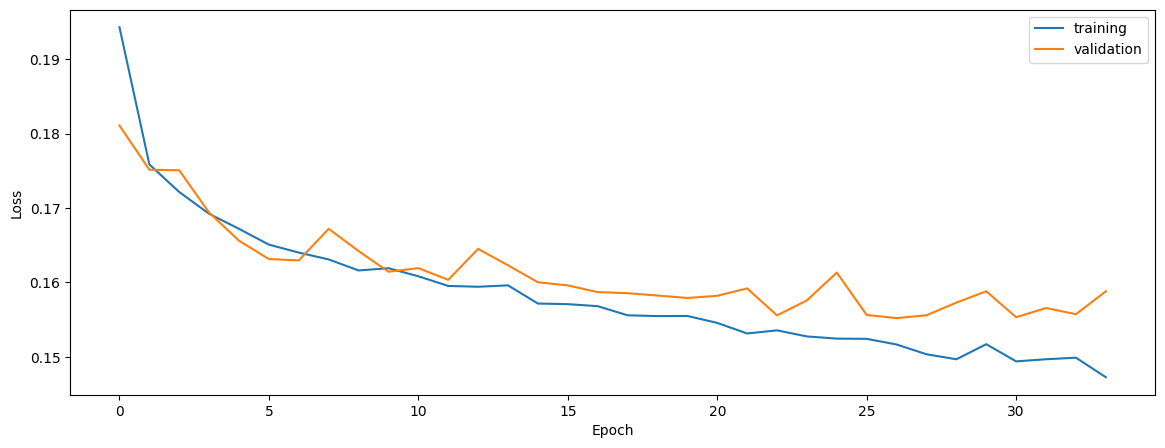

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('normalized')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

normalized
0.6586182432082527
0.640634876738306
0.6407248604481838


In [16]:
print('native')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

native
0.6537267893484238
0.6434800270819229
0.6312788547767457


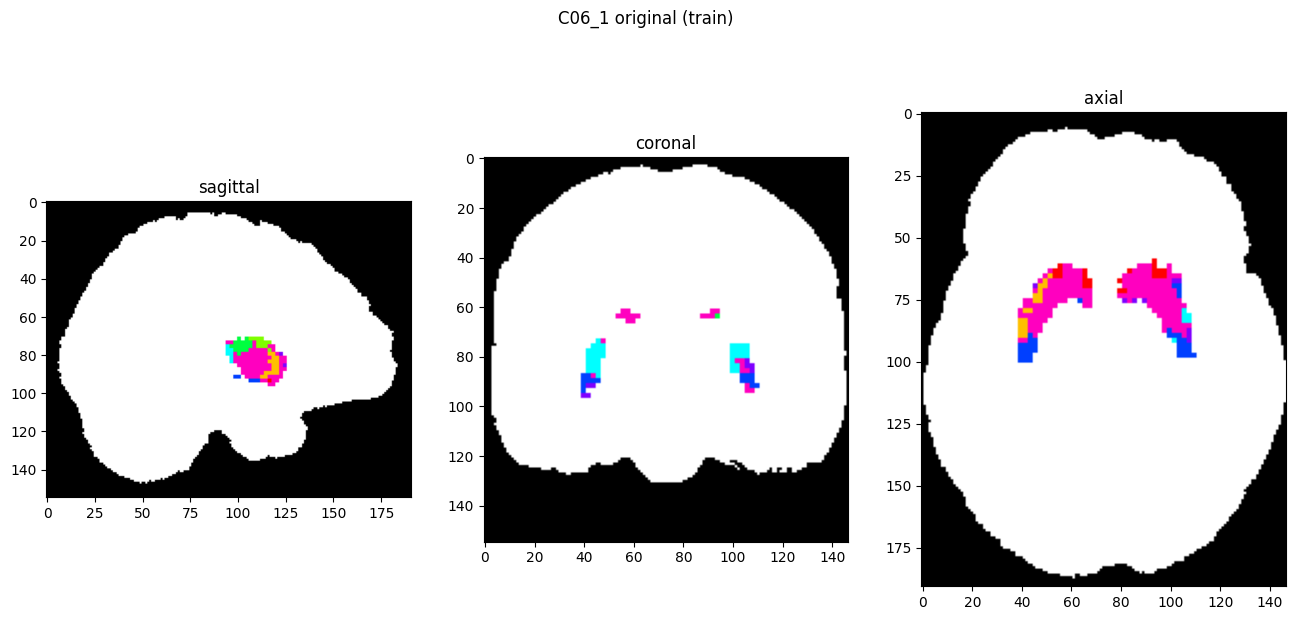

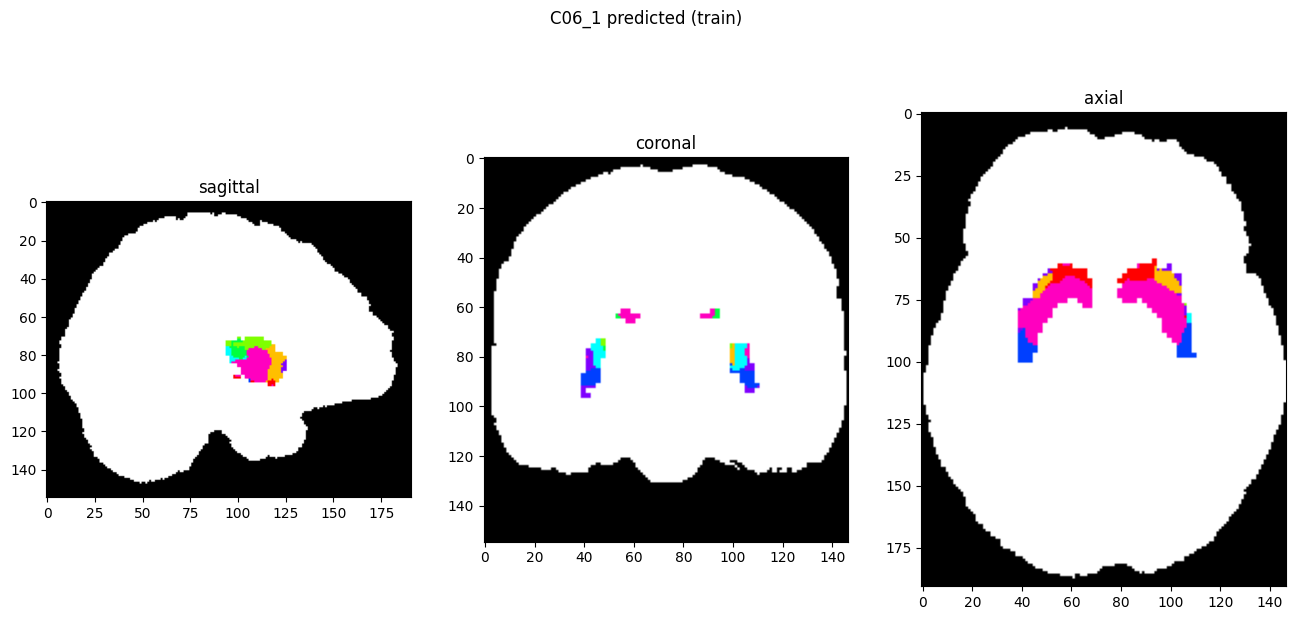

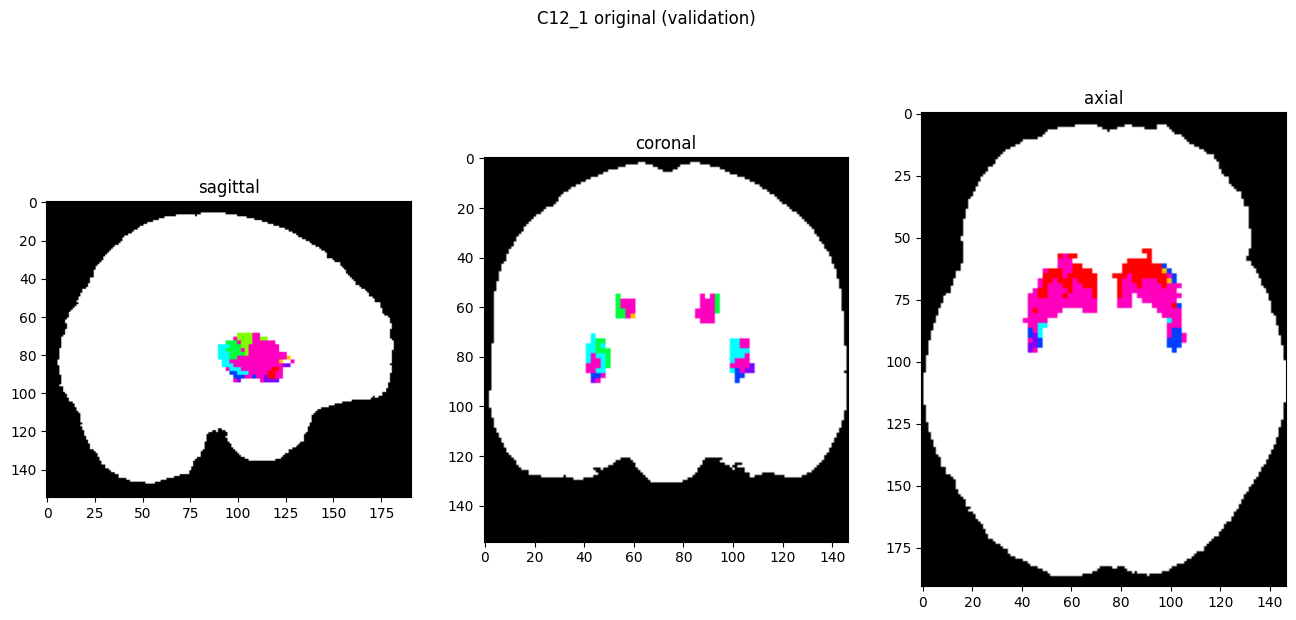

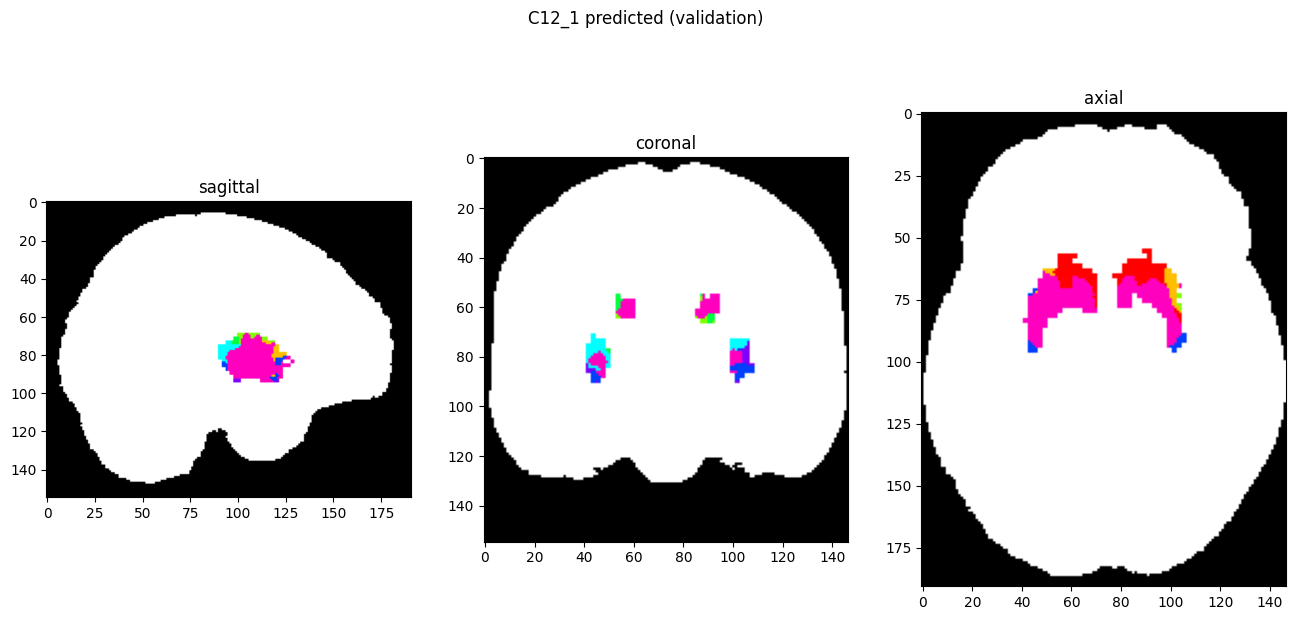

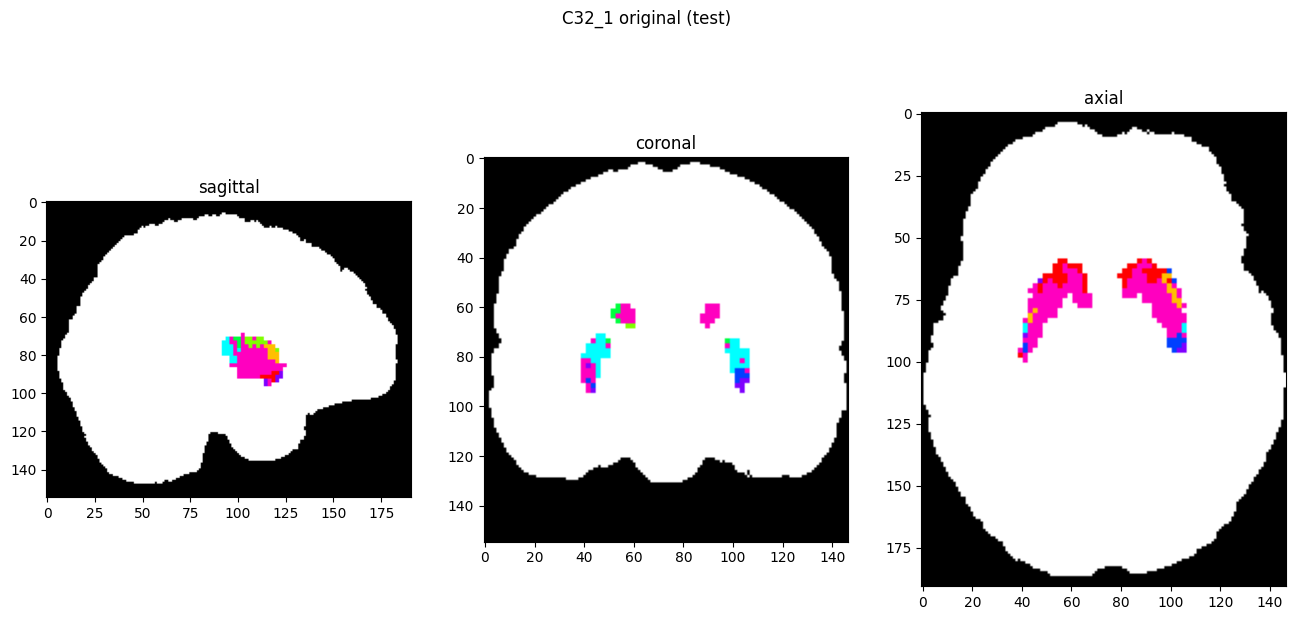

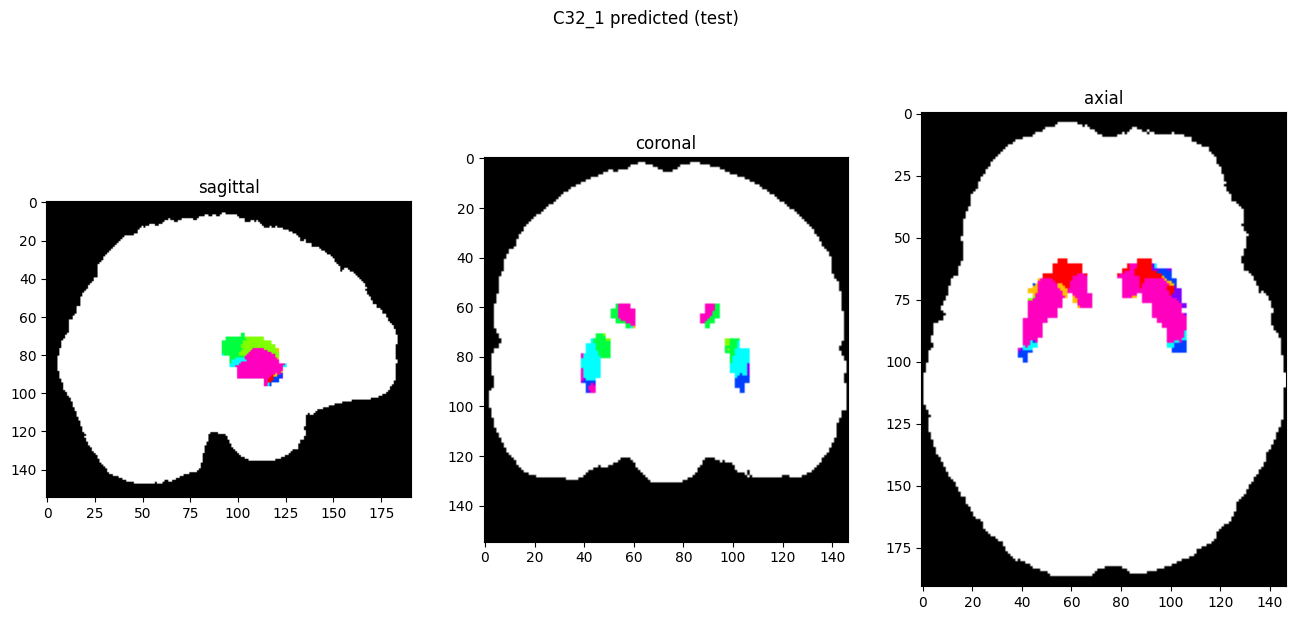

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)